In [44]:
from torch.quasirandom import SobolEngine
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import botorch
import wandb
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model
from mgp_models.utils import *
from mgp_models.acquisition import *
from mgp_models.test_functions import *
import time
import scipy
from torchrl.modules import TruncatedNormal

c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [4]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
import torch

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from botorch.posteriors.fully_bayesian import GaussianMixturePosterior, MCMC_DIM


In [5]:
tkwargs = {
"device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
"dtype": torch.double,
}

In [6]:
# class SALHellingerMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         up = 2*torch.sqrt(sigma_1)*torch.sqrt(sigma_2)
#         down = sigma_1+sigma_2
#         to_sqrt = up.div(down)
#         sqrted = torch.sqrt(to_sqrt)
#         mean_up = mu_1 - mu_2
#         mean_up = mean_up.pow(2)
#         exped = torch.exp(-0.25*mean_up.div(down))
#         right = sqrted* exped
#         hellinger = 1 - right
#         return hellinger.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        



In [7]:
# class SALWassersteinMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         diff_means = mu_1-mu_2
#         diff_stds = torch.sqrt(sigma_2) - torch.sqrt(sigma_1)
#         wasserstein = torch.sqrt(diff_means.pow(2)+diff_stds.pow(2))
#         return wasserstein.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        

In [8]:
# class BALDKLMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.selected_mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
#         dif_means = mu_1-mu_2
#         up = sigma_1 + dif_means.pow(2)
#         KL = left + up.div(2*sigma_2) - 0.5
#         return KL.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_yhat(gp, test_X, tkwargs, batch_size = 100):

    total_batches = test_X.size(0) // batch_size
    Y_full = torch.Tensor().to(**tkwargs)
    if total_batches==0:
        posterior = gp.posterior(test_X)
        Y_full = posterior.mean
    else:
        for i in range(total_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            batch_X = test_X[start_idx:end_idx]
            posterior = gp.posterior(batch_X)
            Y_hat = posterior.mean
            Y_full = torch.cat((Y_full, Y_hat),1)
    return Y_full
import seaborn as sns  # Import seaborn for KDE plot


def plot_gps(test_X, std, synthetic_function, Y_hat, X_train, Y_train, acq_values=None, weights=None):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()
    if acq_values is not None:
        acq_values = acq_values.detach().squeeze().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    if acq_values is not None:
        df['acq_values'] = acq_values

    gp_cols = ['gp_' + str(i) for i in range(len(gps_y))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = gps_y[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)

    if weights is not None:
        norm = plt.Normalize(min(weights), max(weights))
        cmap = plt.cm.viridis

    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    for i, gp_col in enumerate(gp_cols):
        if weights is None or weights[i] > 0:
            color = cmap(norm(weights[i])) if weights is not None else 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='gold', s=200, marker='*', label='Queried points', zorder=5)
    ax1.legend()
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot
    x_min, x_max = ax1.get_xlim()

    # Plotting the KDE for acq_values on the second subplot (ax2) with x-axis limits
    if acq_values is not None:
        sns.kdeplot(x=df.x, weights=df.acq_values, ax=ax2, fill=True, color='green', clip=(x_min, x_max), bw_adjust=0.5)
        ax2.set_xlim(x_min, x_max)  # Apply the same x-axis limits as the upper plot
        ax2.set_ylabel('Acquisition Value Density')
        ax2.set_xlabel('X')

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_samples_gp(test_X, std, synthetic_function,Y_hat, samples, index, X_train, Y_train):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    samples_selected = samples[:,index,:].detach().numpy()
    df['gp_mean'] = gps_y[index,:]
    gp_cols = ['gp_' + str(i) for i in range(len(samples_selected))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = samples_selected[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)


    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    for i, gp_col in enumerate(gp_cols):
            color = 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='gold', s=200, marker='*', label='Queried points', zorder=5)
    ax1.legend()
    ax1.plot(df.x, df.gp_mean, color='orange')
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [11]:
DIM = 1
BOUNDS =  [[0, 20]]
type = 'part_bayesian'

{'noise': tensor([0.4365], dtype=torch.float64), 'lengthscale': tensor([[0.0301]], dtype=torch.float64), 'outputscale': tensor([0.2100], dtype=torch.float64), 'mean': tensor([-0.0083], dtype=torch.float64)}


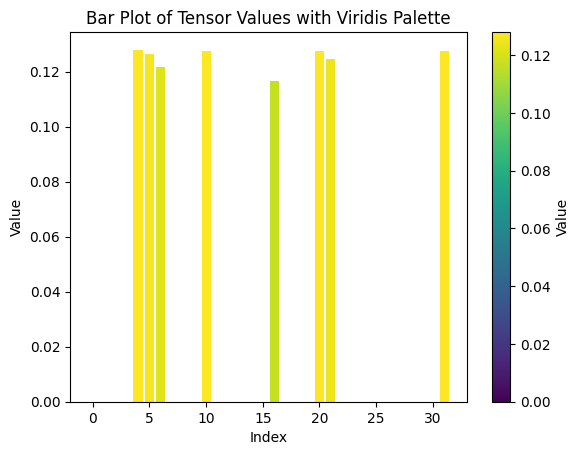

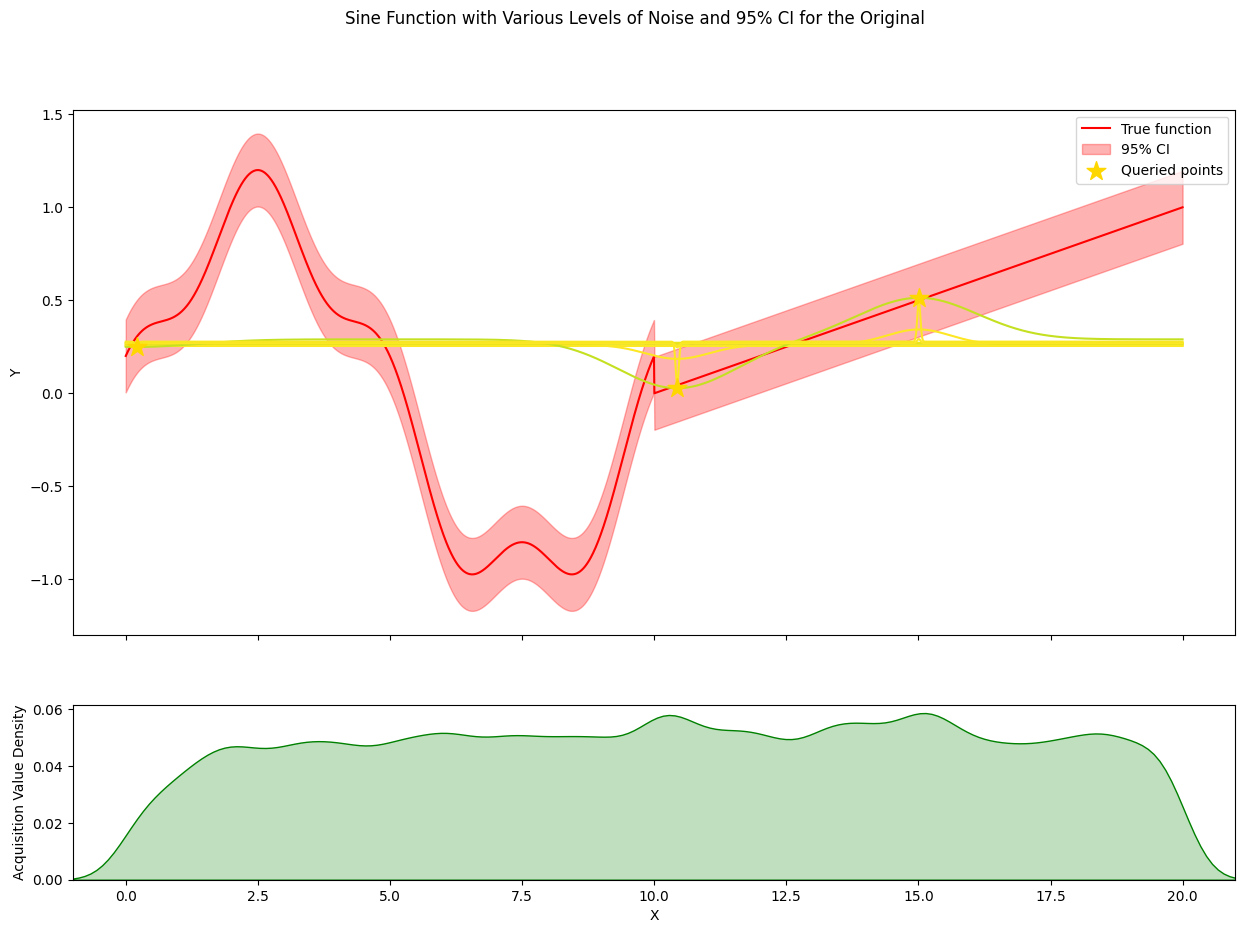

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

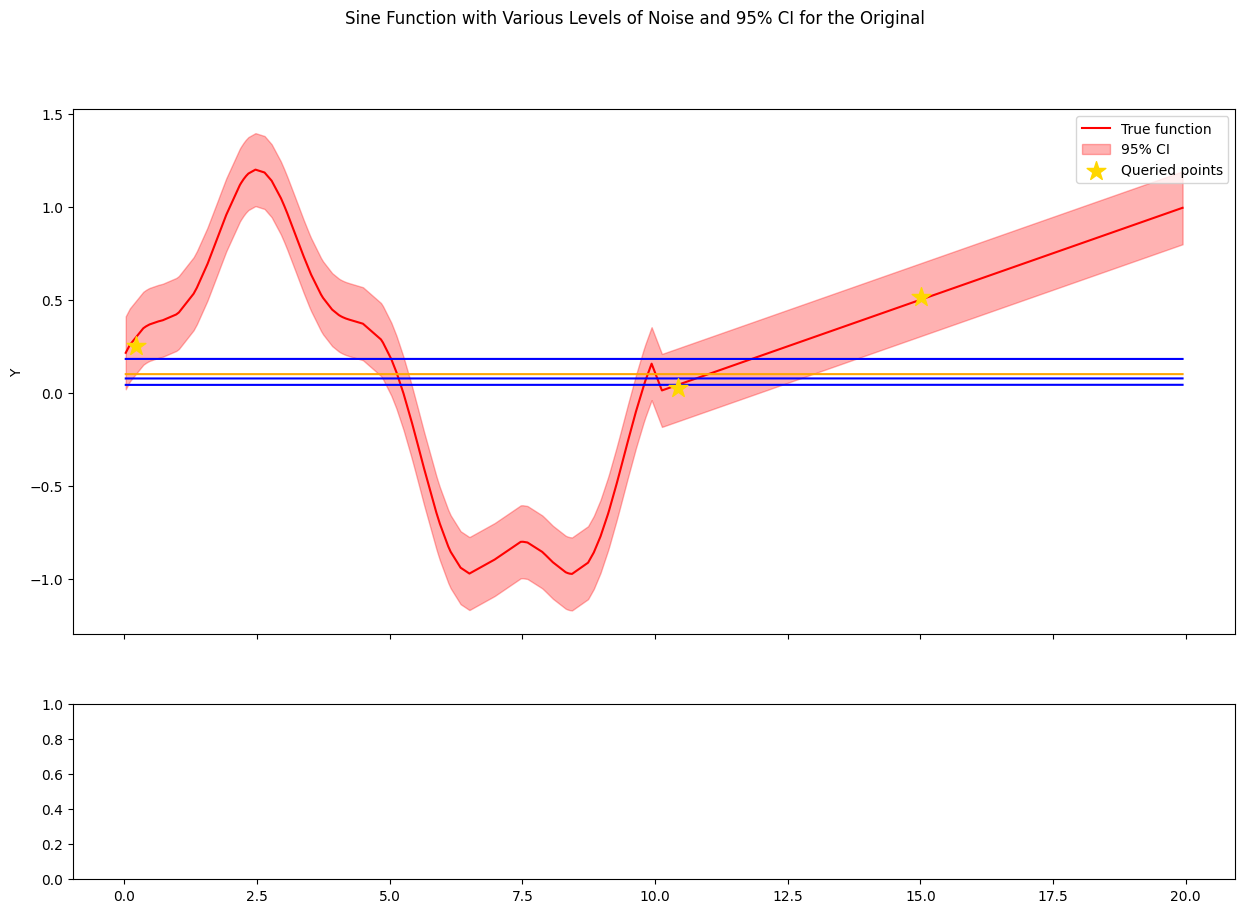

tensor([[0.0875],
        [0.0919],
        [0.0760],
        ...,
        [0.0812],
        [0.0805],
        [0.0812]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.1464], dtype=torch.float64), 'lengthscale': tensor([[0.0266]], dtype=torch.float64), 'outputscale': tensor([0.6068], dtype=torch.float64), 'mean': tensor([-0.2353], dtype=torch.float64)}


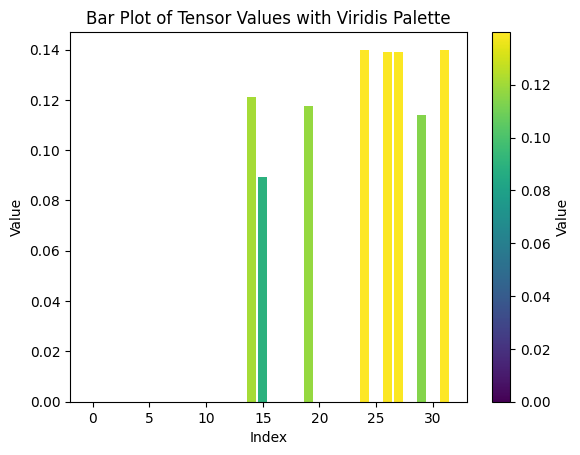

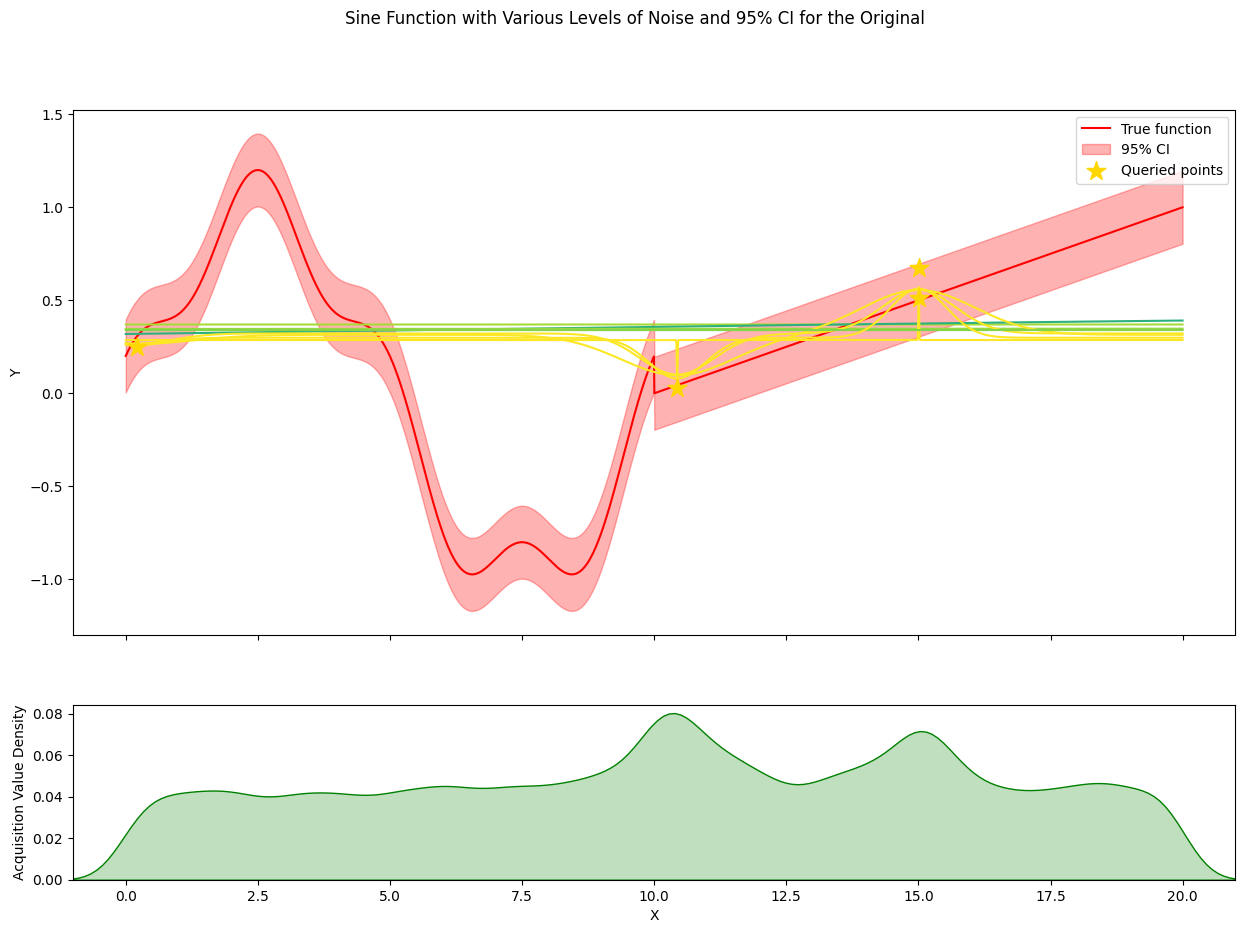

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

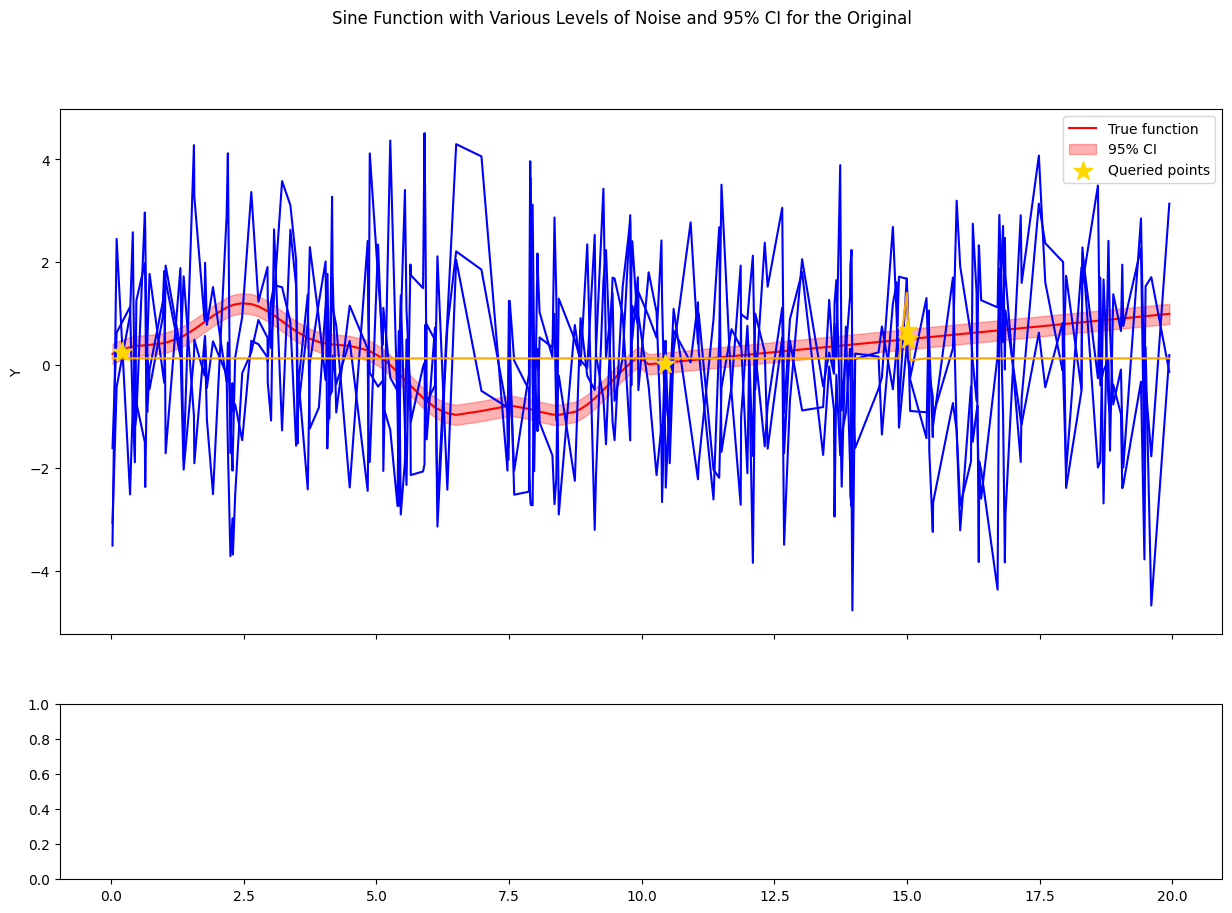

tensor([[0.1226],
        [0.1190],
        [0.0732],
        ...,
        [0.0747],
        [0.0768],
        [0.0782]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0870], dtype=torch.float64), 'lengthscale': tensor([[0.0003]], dtype=torch.float64), 'outputscale': tensor([0.6180], dtype=torch.float64), 'mean': tensor([-0.0028], dtype=torch.float64)}


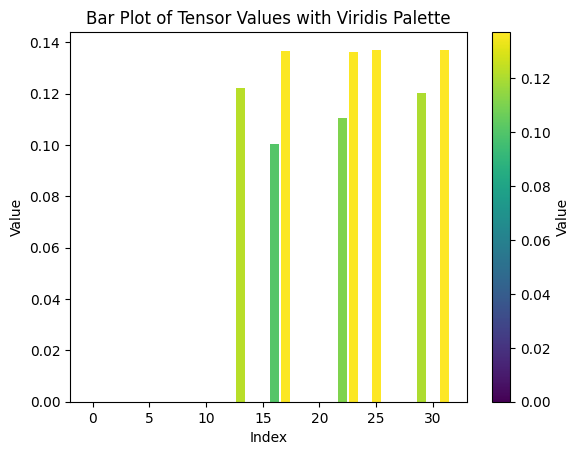

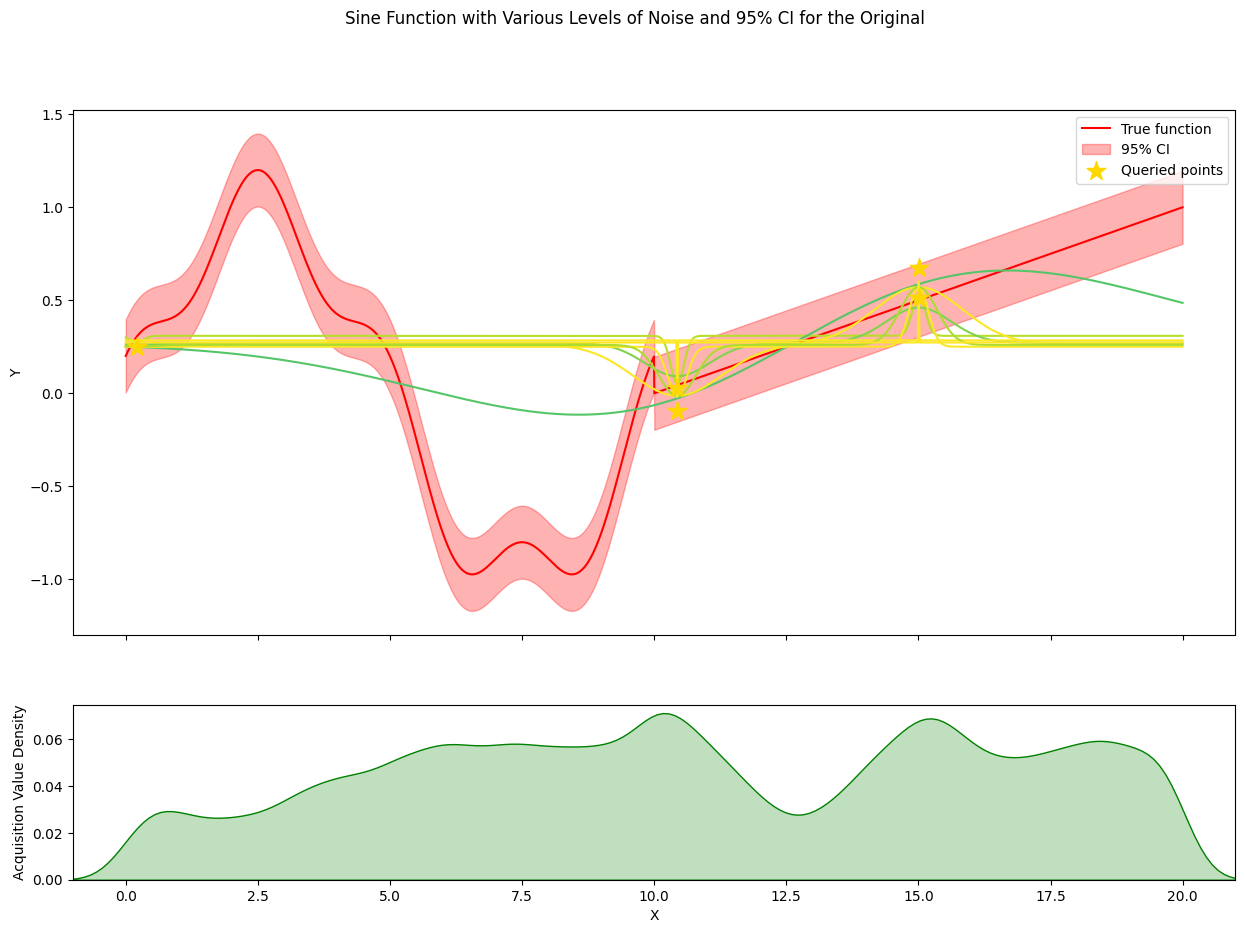

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

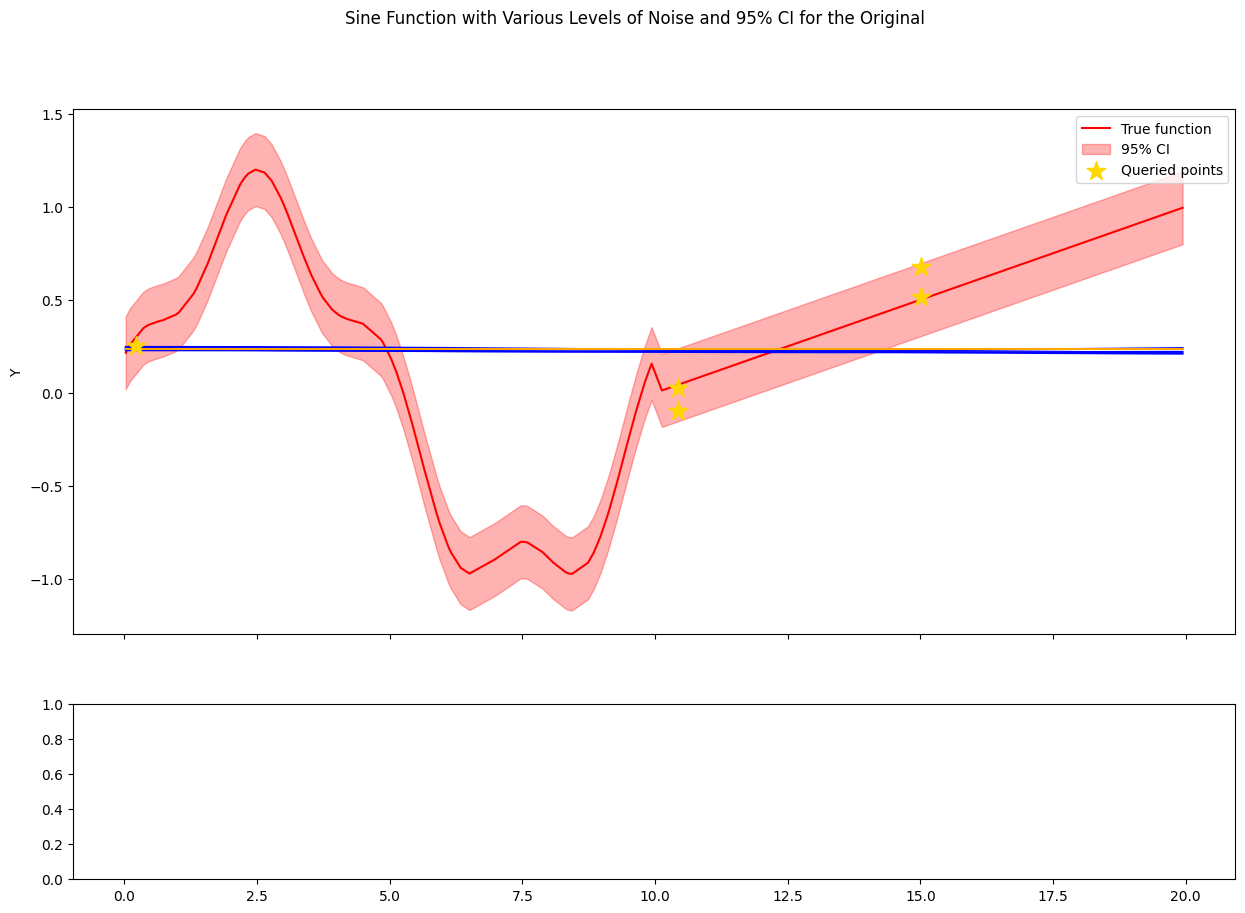

tensor([[0.1372],
        [0.1374],
        [0.0476],
        ...,
        [0.1021],
        [0.1095],
        [0.1135]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.1058], dtype=torch.float64), 'lengthscale': tensor([[0.0041]], dtype=torch.float64), 'outputscale': tensor([0.6044], dtype=torch.float64), 'mean': tensor([-0.1534], dtype=torch.float64)}


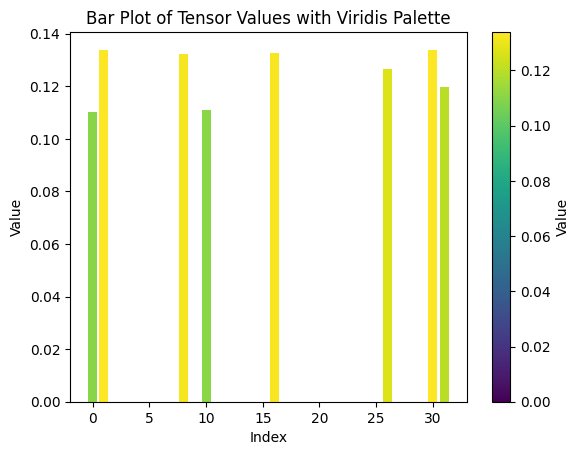

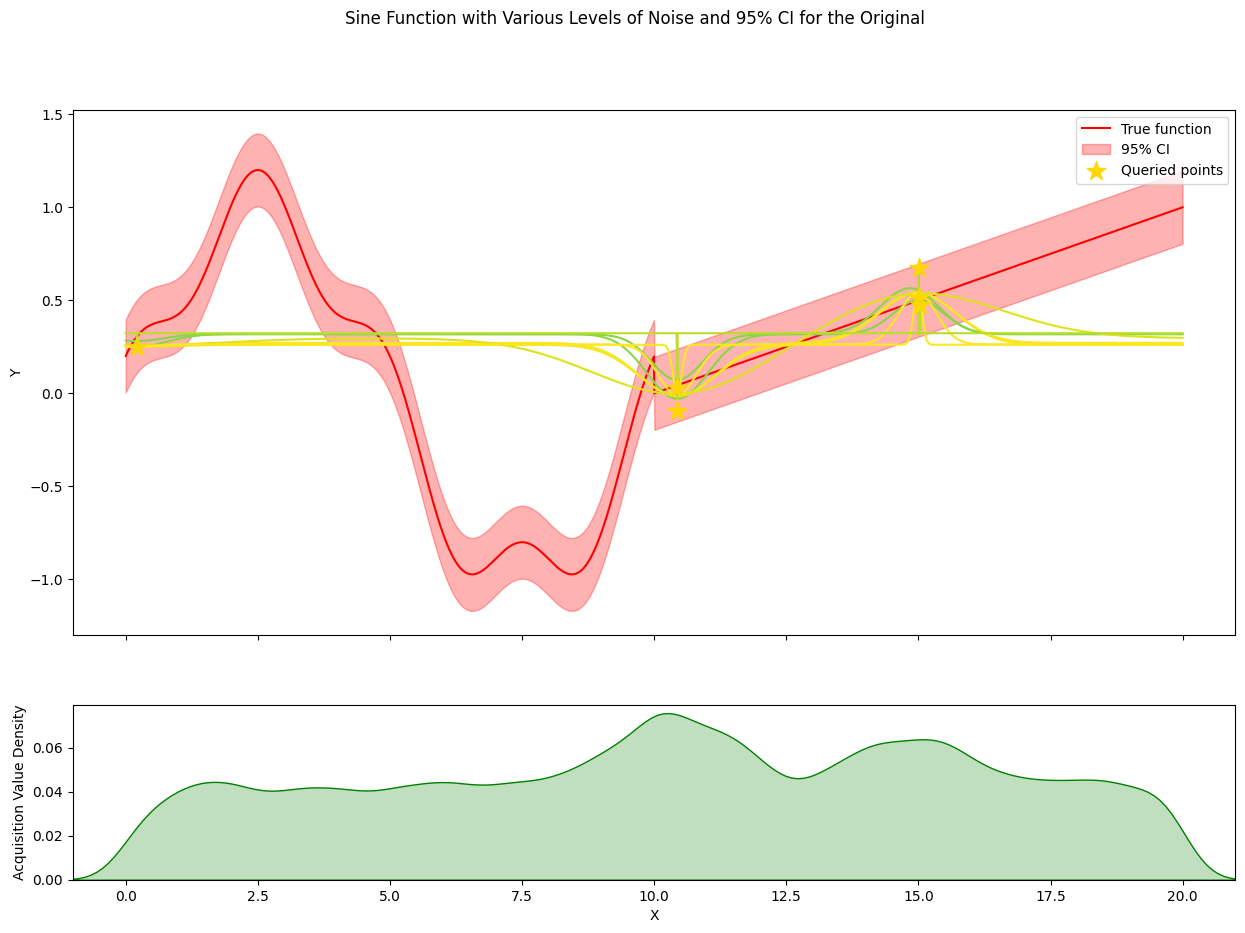

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

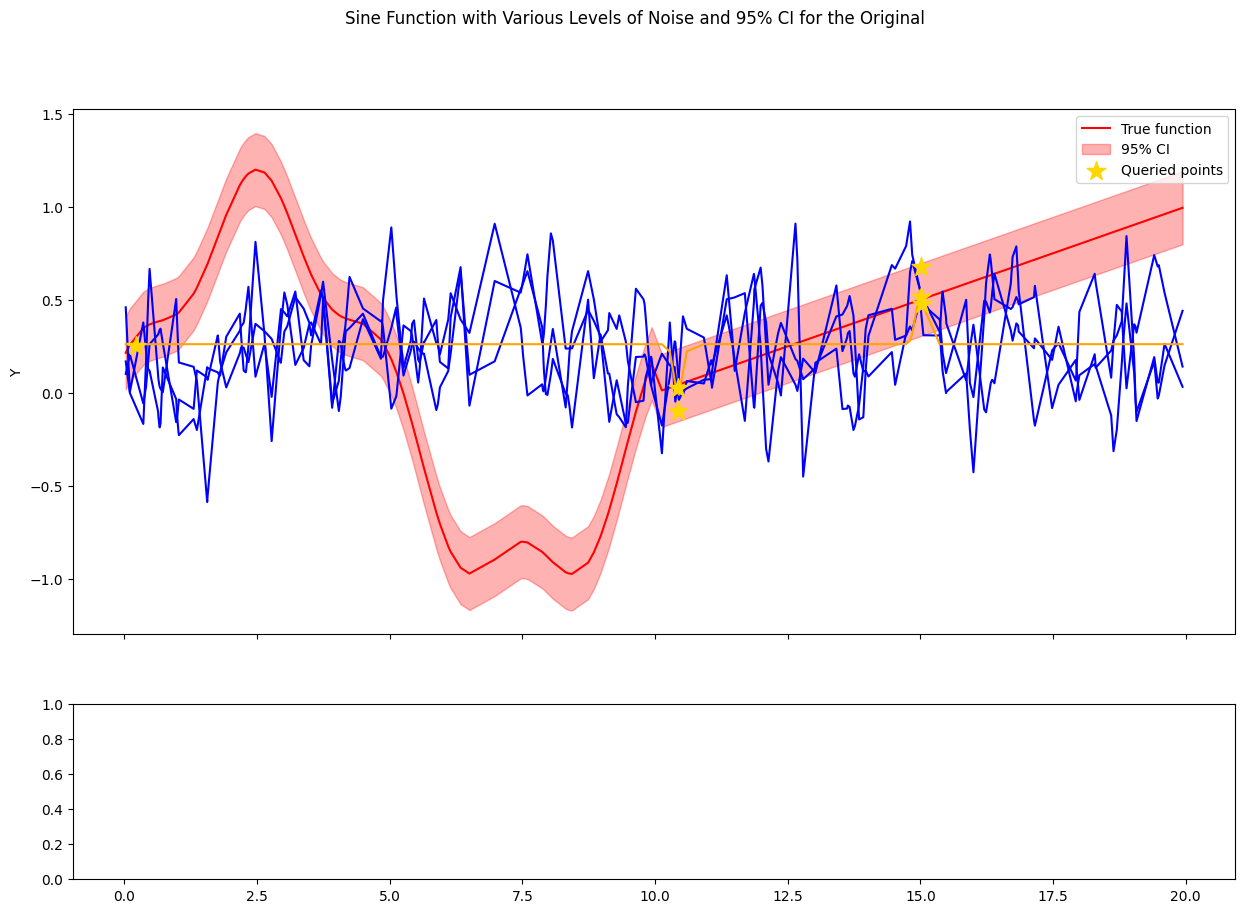

tensor([[0.1232],
        [0.1059],
        [0.0759],
        ...,
        [0.0736],
        [0.0770],
        [0.0737]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.1025], dtype=torch.float64), 'lengthscale': tensor([[0.0673]], dtype=torch.float64), 'outputscale': tensor([0.6033], dtype=torch.float64), 'mean': tensor([-0.0179], dtype=torch.float64)}


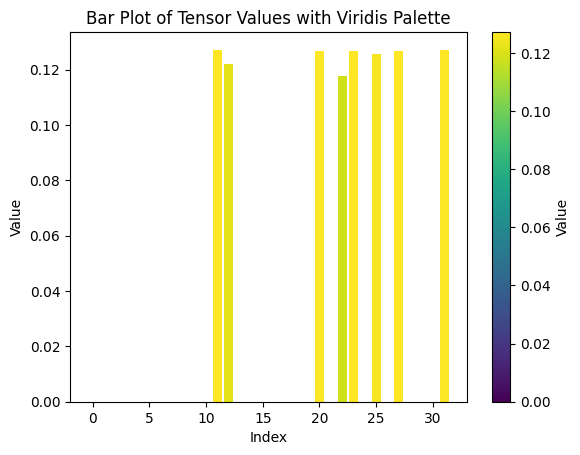

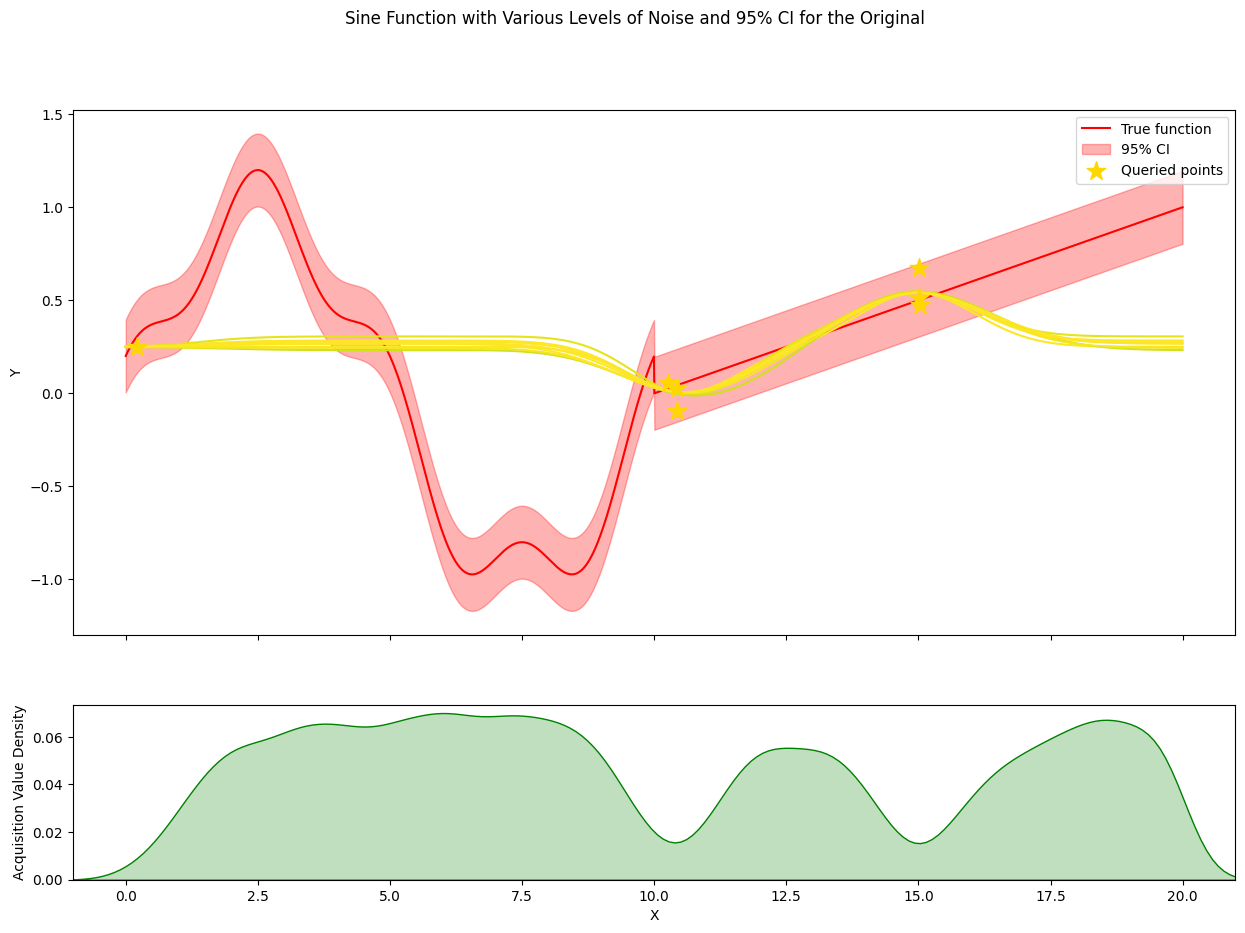

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

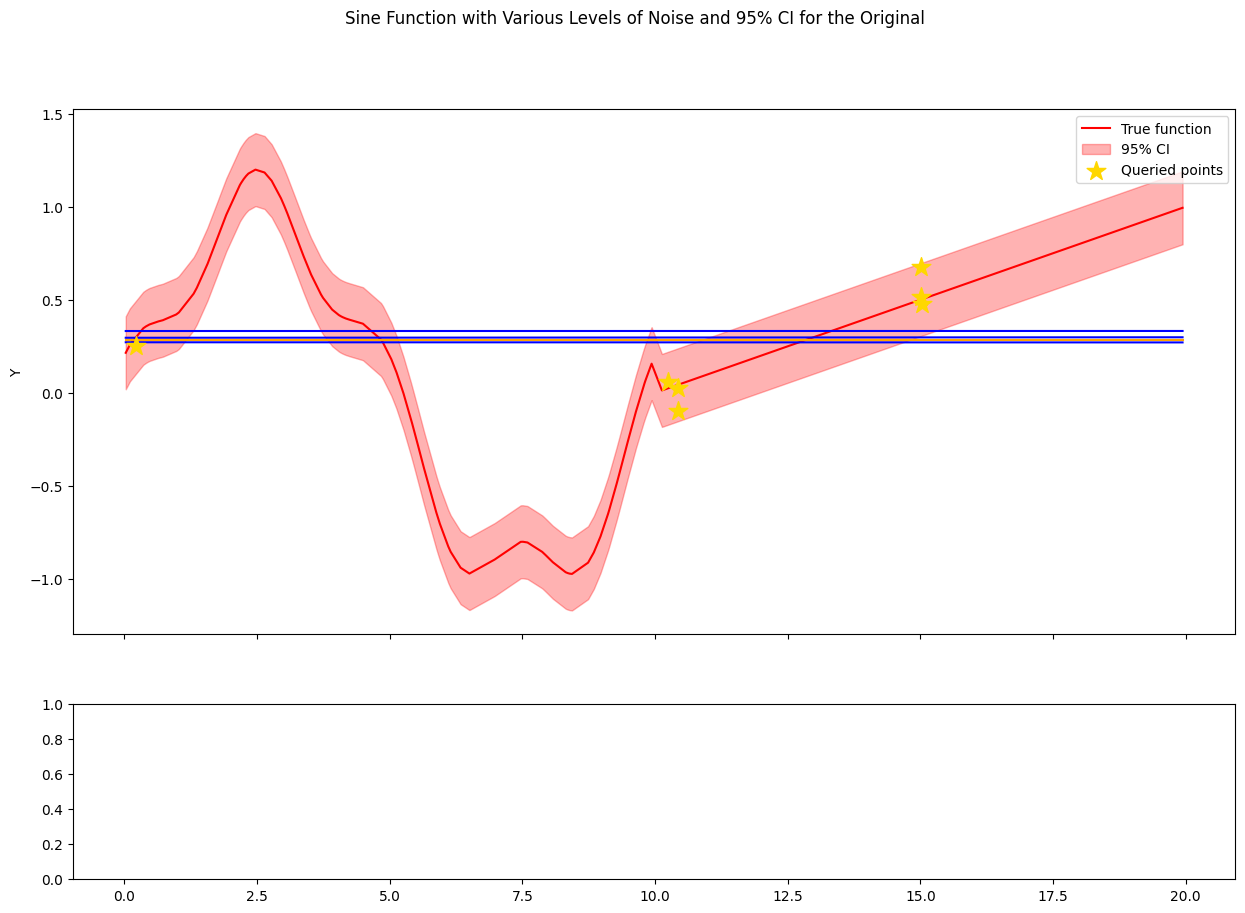

tensor([[0.0117],
        [0.0089],
        [0.0347],
        ...,
        [0.0453],
        [0.0448],
        [0.0452]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0403], dtype=torch.float64), 'lengthscale': tensor([[0.0538]], dtype=torch.float64), 'outputscale': tensor([1.0724], dtype=torch.float64), 'mean': tensor([-0.2808], dtype=torch.float64)}


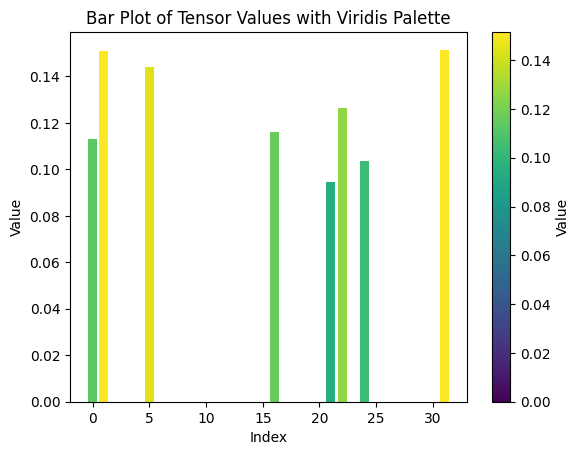

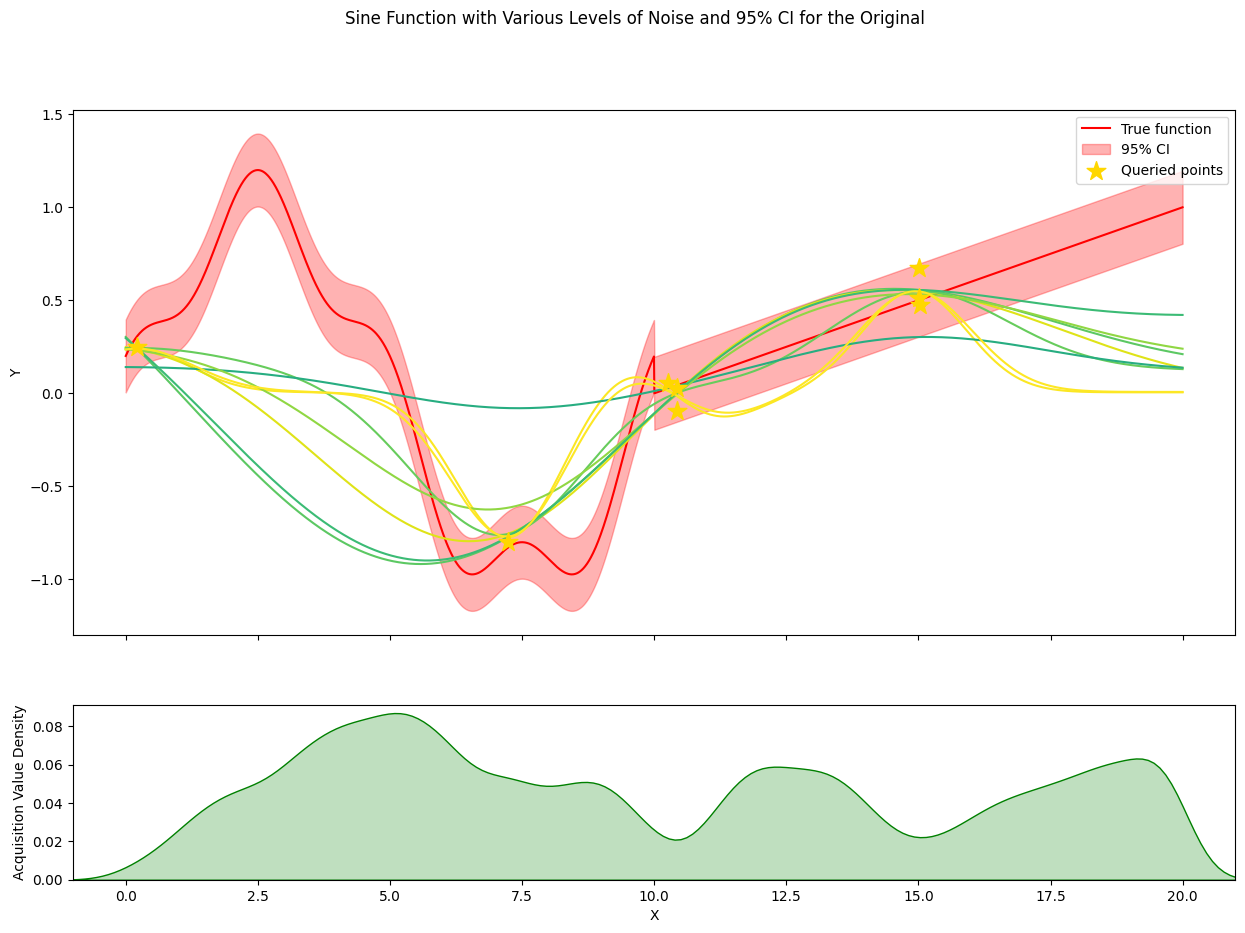

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

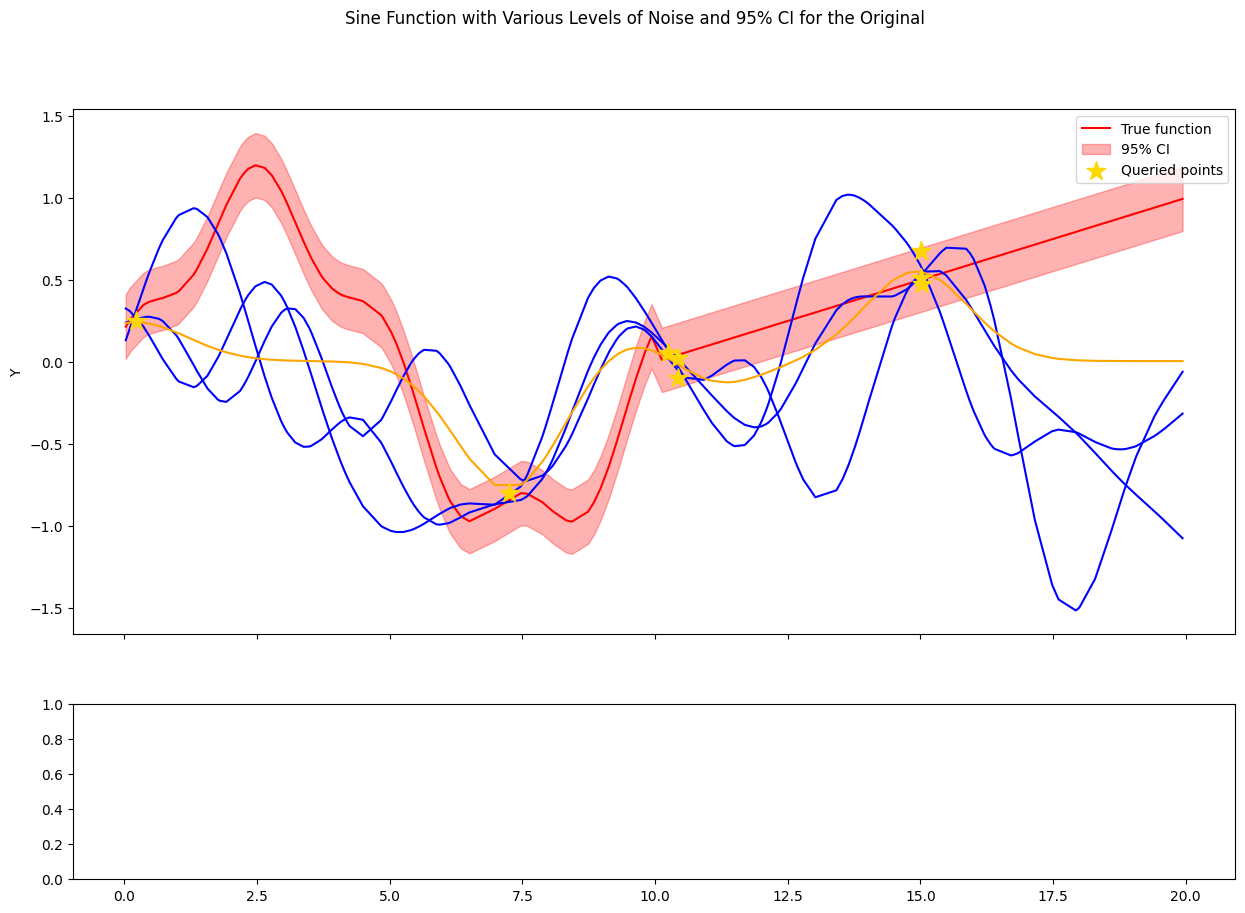

tensor([[0.0982],
        [0.0681],
        [0.1661],
        ...,
        [0.3596],
        [0.1659],
        [0.2870]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0468], dtype=torch.float64), 'lengthscale': tensor([[0.0437]], dtype=torch.float64), 'outputscale': tensor([1.0388], dtype=torch.float64), 'mean': tensor([-0.2116], dtype=torch.float64)}


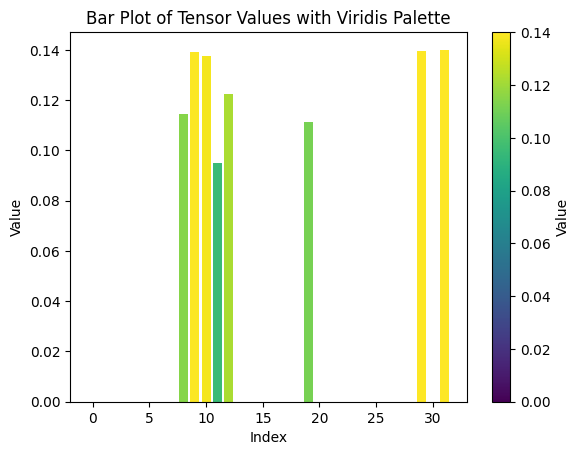

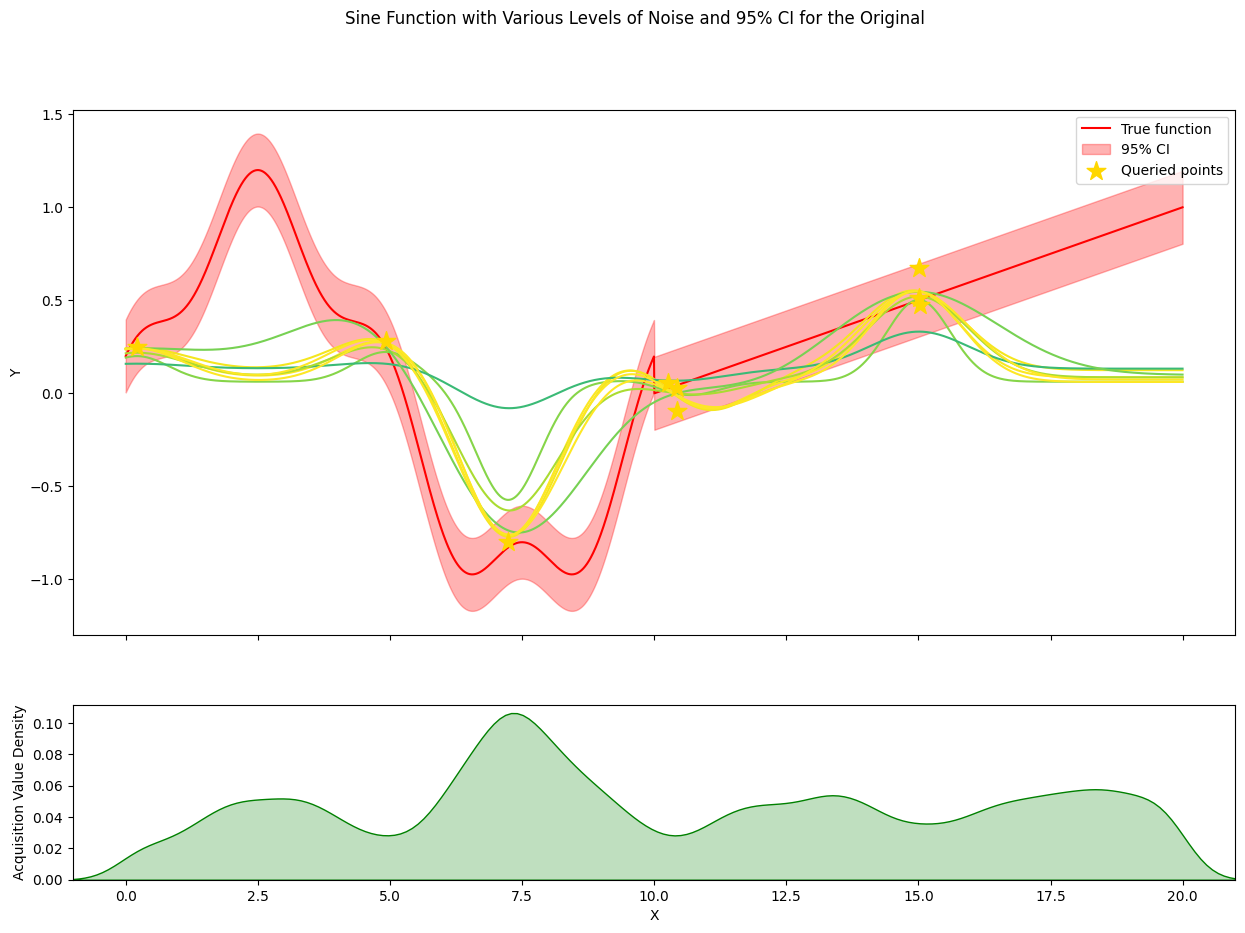

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

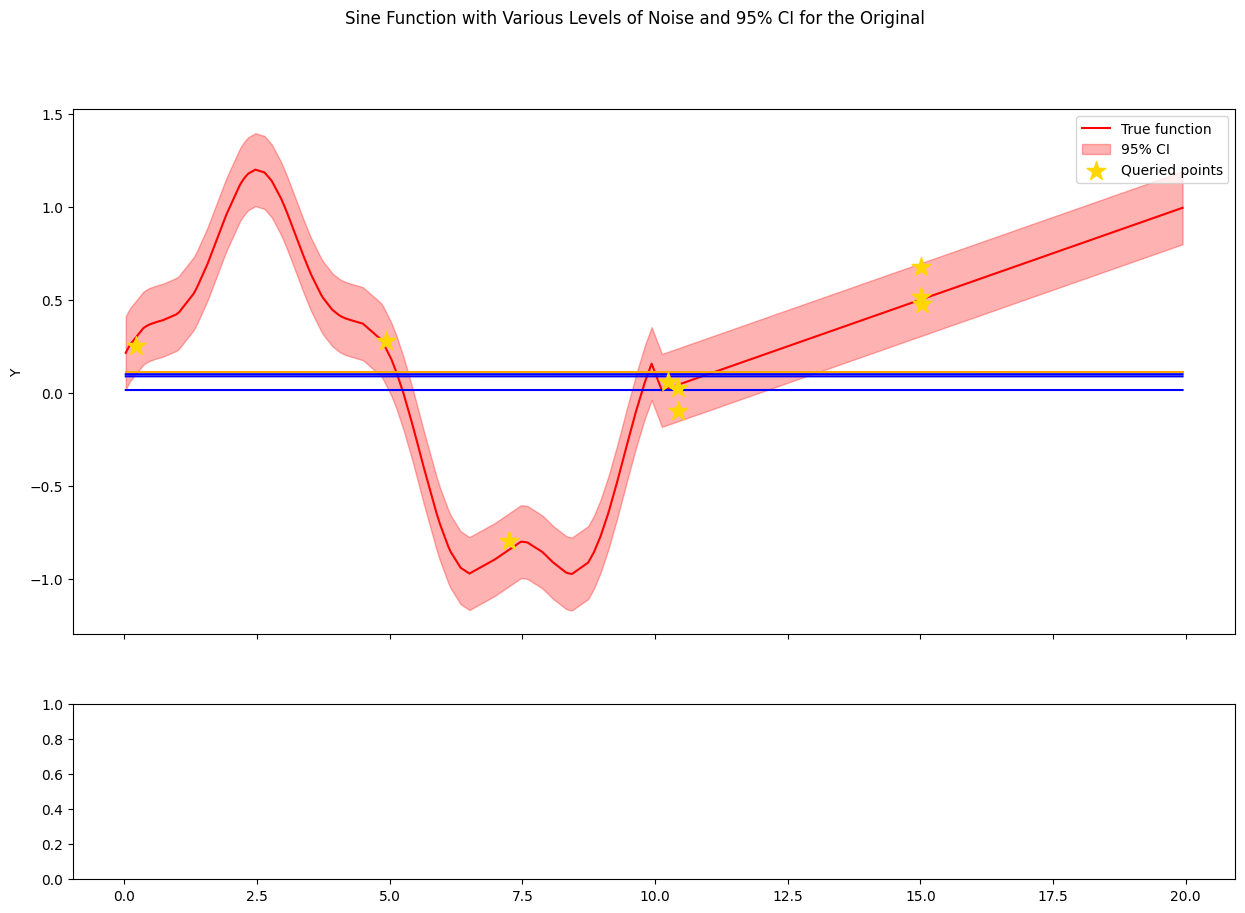

tensor([[0.0493],
        [0.0520],
        [0.0800],
        ...,
        [0.0488],
        [0.1562],
        [0.0964]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0272], dtype=torch.float64), 'lengthscale': tensor([[0.0433]], dtype=torch.float64), 'outputscale': tensor([0.7686], dtype=torch.float64), 'mean': tensor([0.0130], dtype=torch.float64)}


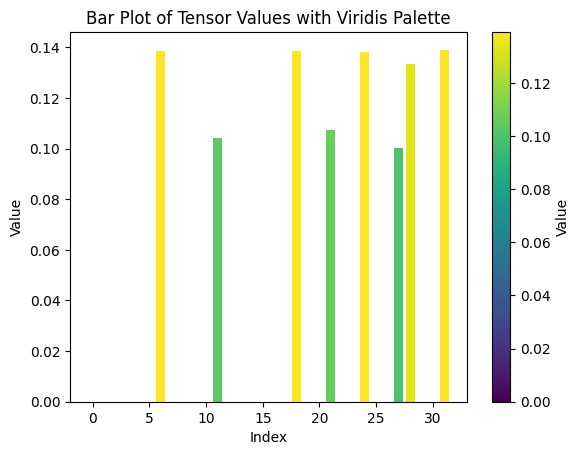

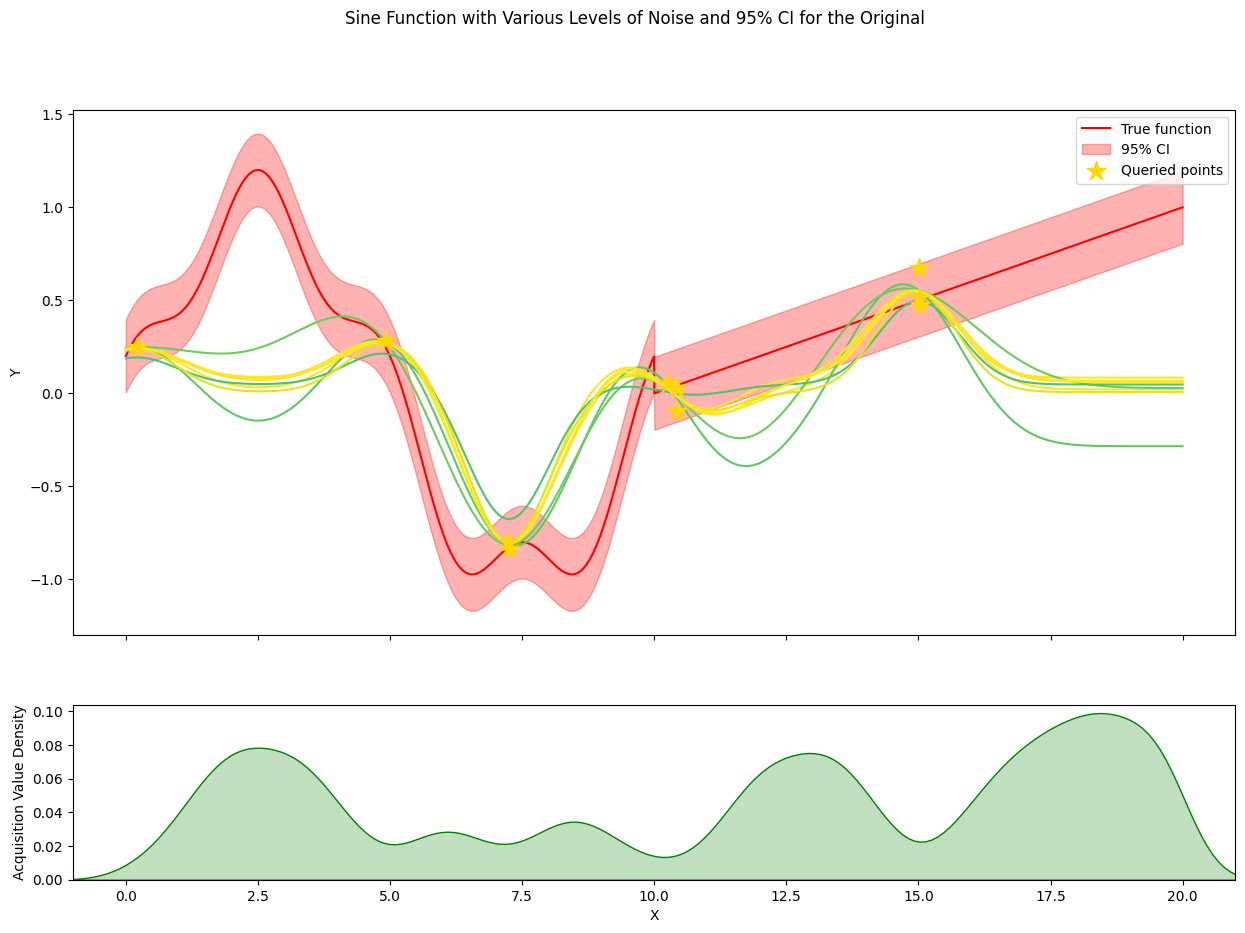

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

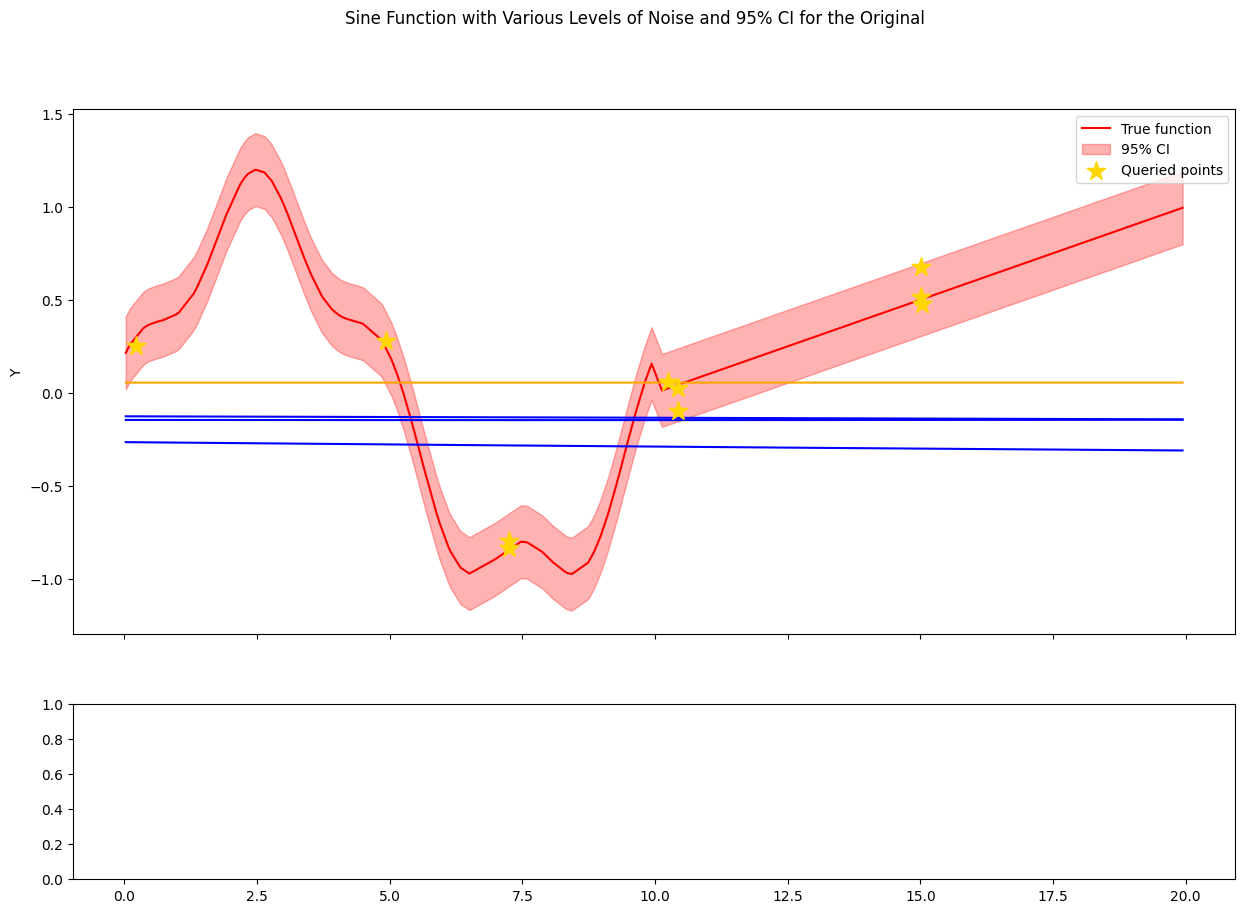

tensor([[0.0325],
        [0.0476],
        [0.2235],
        ...,
        [0.0334],
        [0.1018],
        [0.2962]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0241], dtype=torch.float64), 'lengthscale': tensor([[0.0477]], dtype=torch.float64), 'outputscale': tensor([0.8605], dtype=torch.float64), 'mean': tensor([0.1160], dtype=torch.float64)}


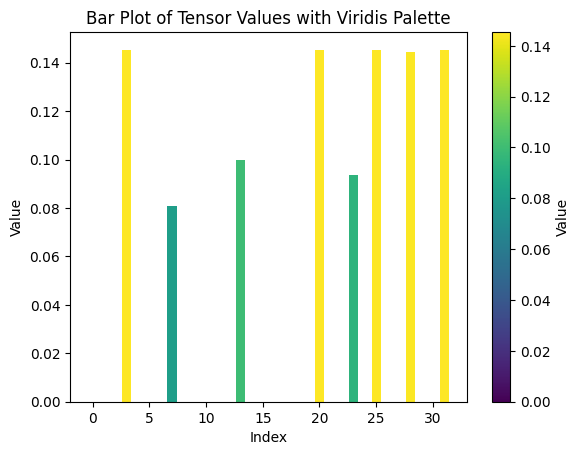

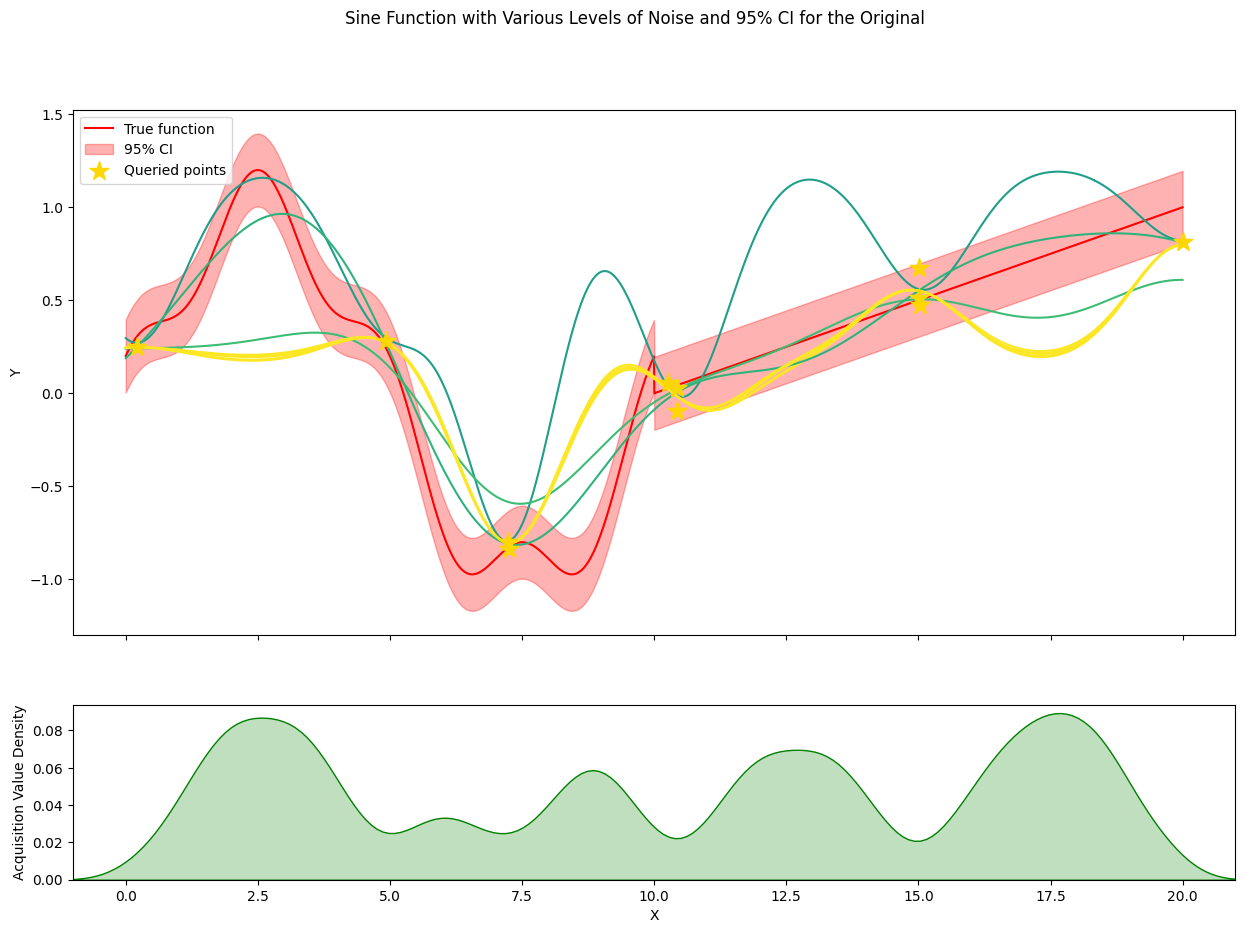

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

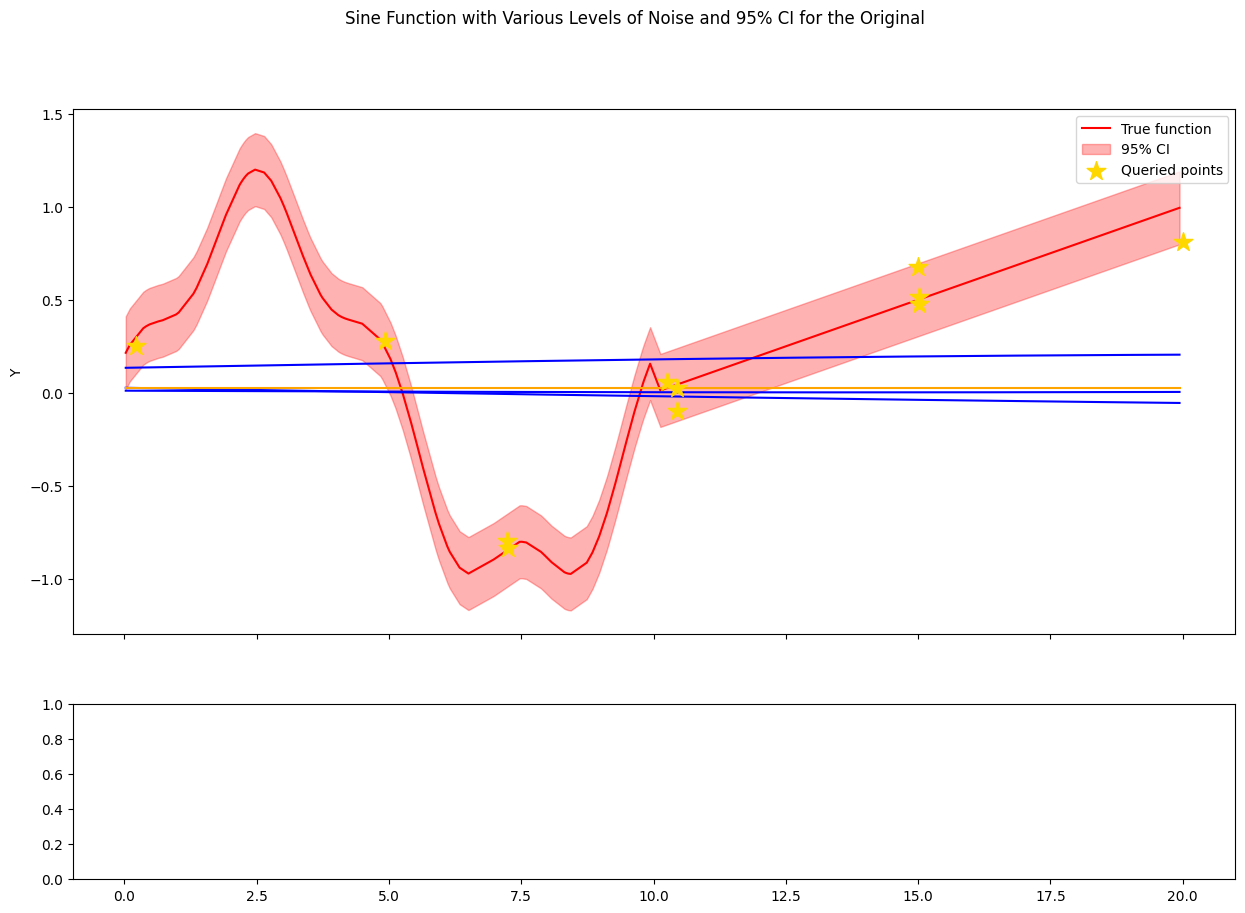

tensor([[0.0937],
        [0.0652],
        [0.3067],
        ...,
        [0.0630],
        [0.1427],
        [0.0869]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0220], dtype=torch.float64), 'lengthscale': tensor([[0.0590]], dtype=torch.float64), 'outputscale': tensor([0.8948], dtype=torch.float64), 'mean': tensor([0.1646], dtype=torch.float64)}


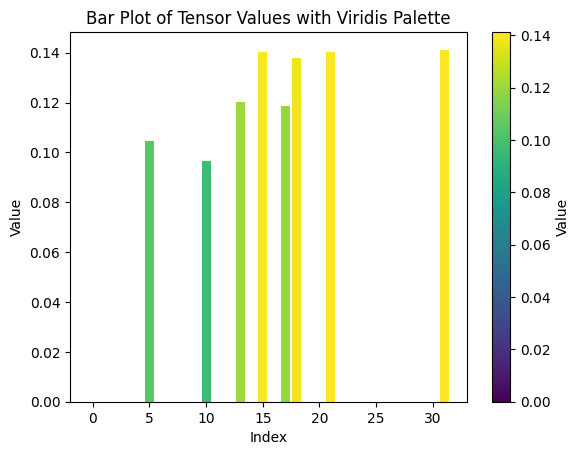

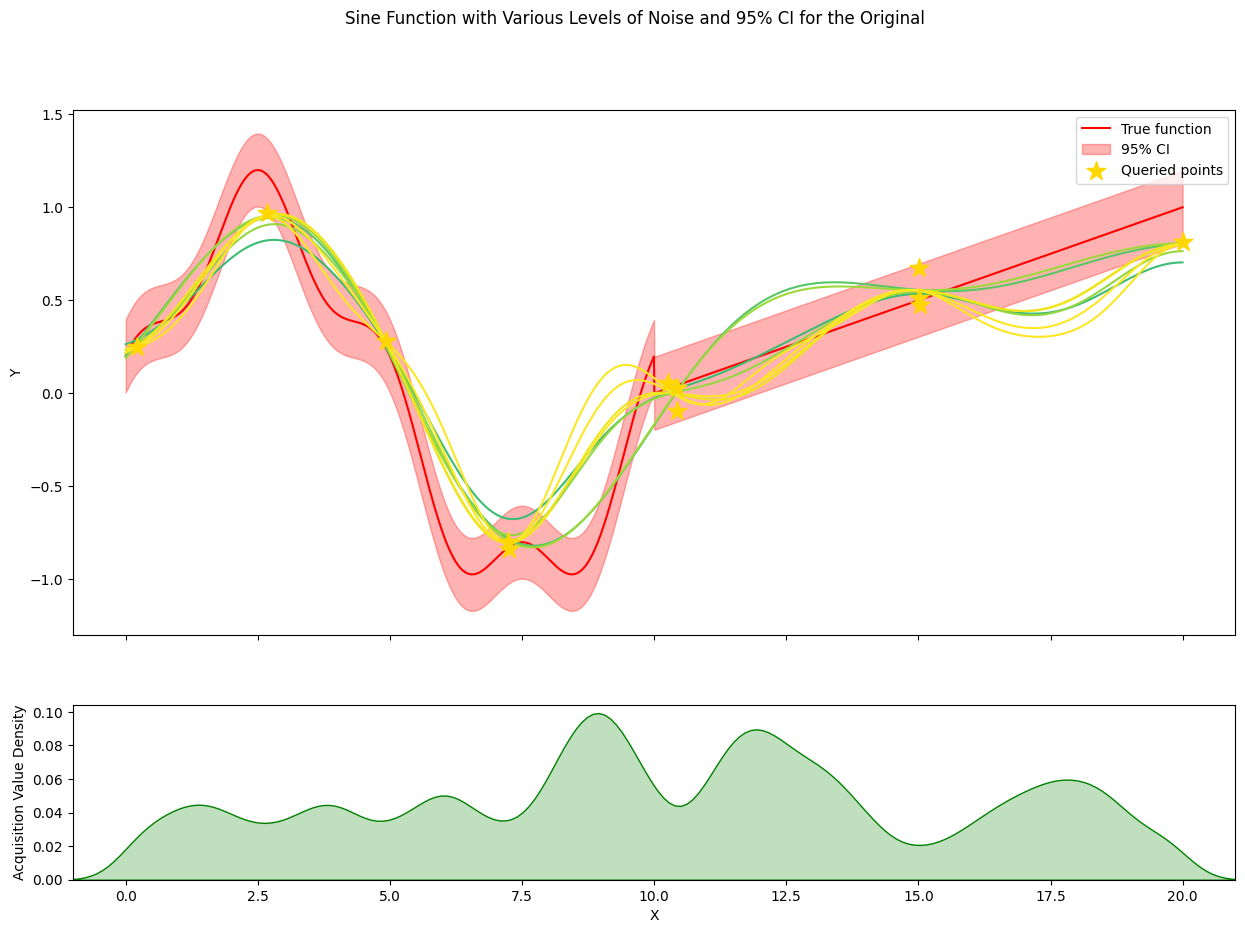

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

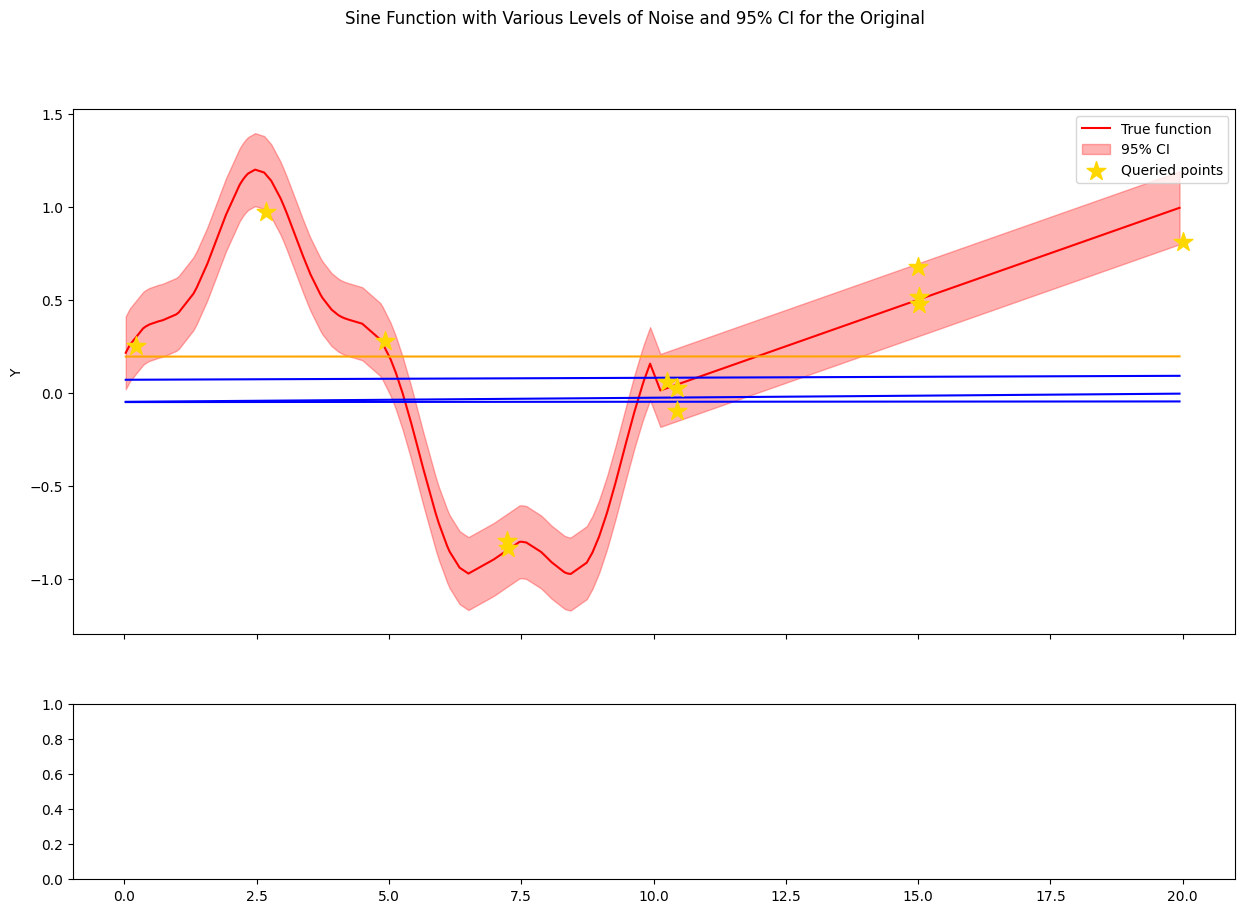

tensor([[0.1009],
        [0.0297],
        [0.0795],
        ...,
        [0.0607],
        [0.1061],
        [0.0478]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0299], dtype=torch.float64), 'lengthscale': tensor([[0.1119]], dtype=torch.float64), 'outputscale': tensor([1.0279], dtype=torch.float64), 'mean': tensor([0.3320], dtype=torch.float64)}


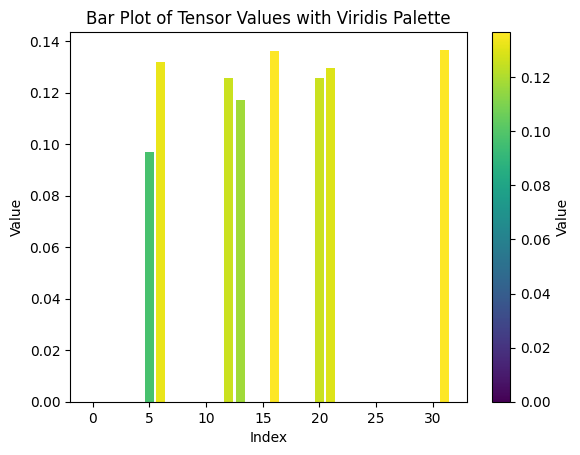

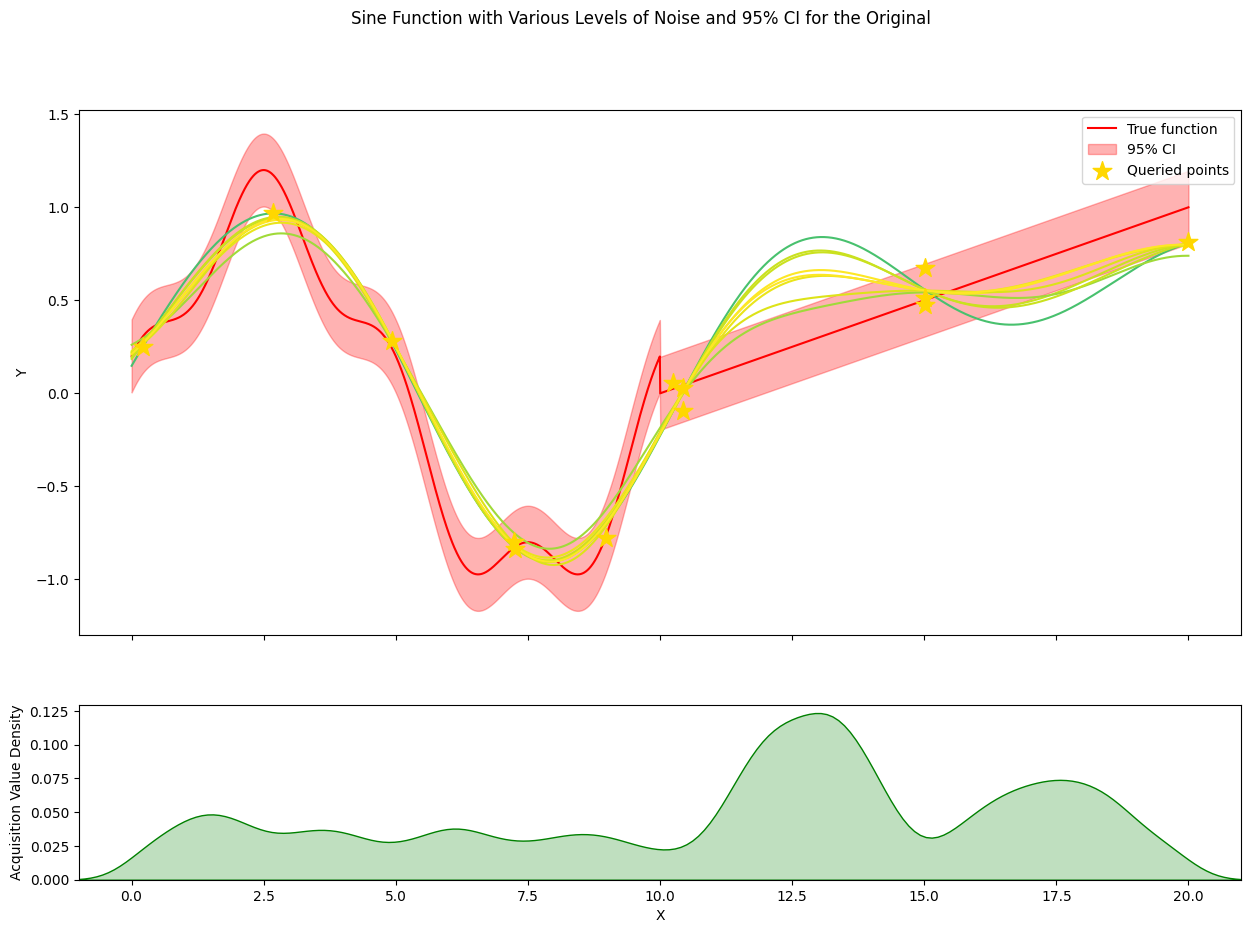

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

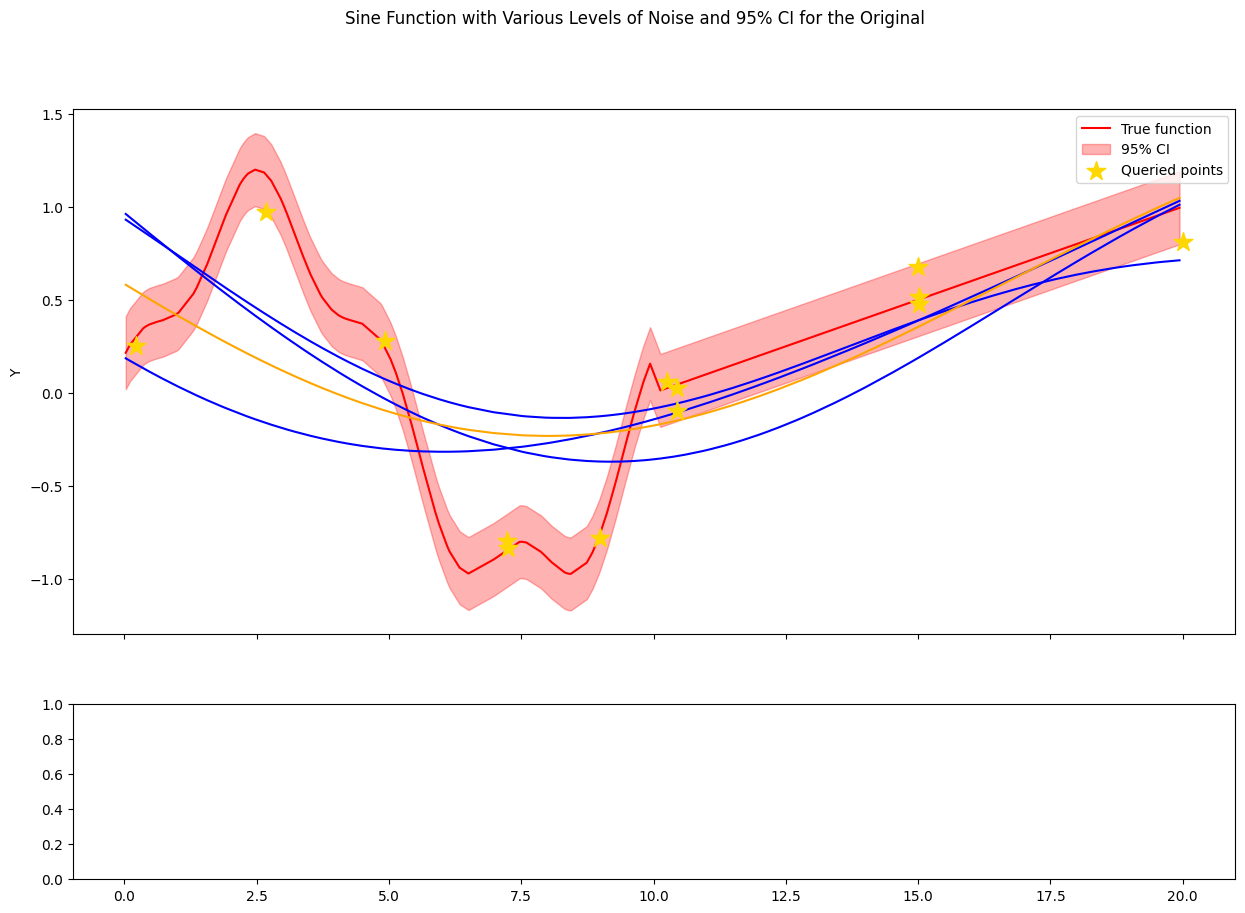

tensor([[0.0201],
        [0.0258],
        [0.0489],
        ...,
        [0.0247],
        [0.0313],
        [0.0259]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0316], dtype=torch.float64), 'lengthscale': tensor([[0.1074]], dtype=torch.float64), 'outputscale': tensor([0.9516], dtype=torch.float64), 'mean': tensor([0.2908], dtype=torch.float64)}


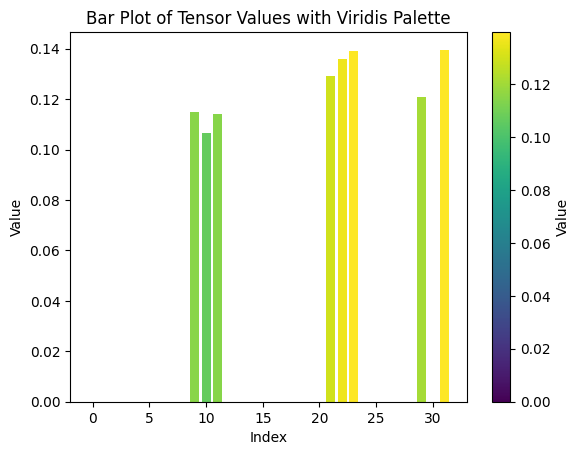

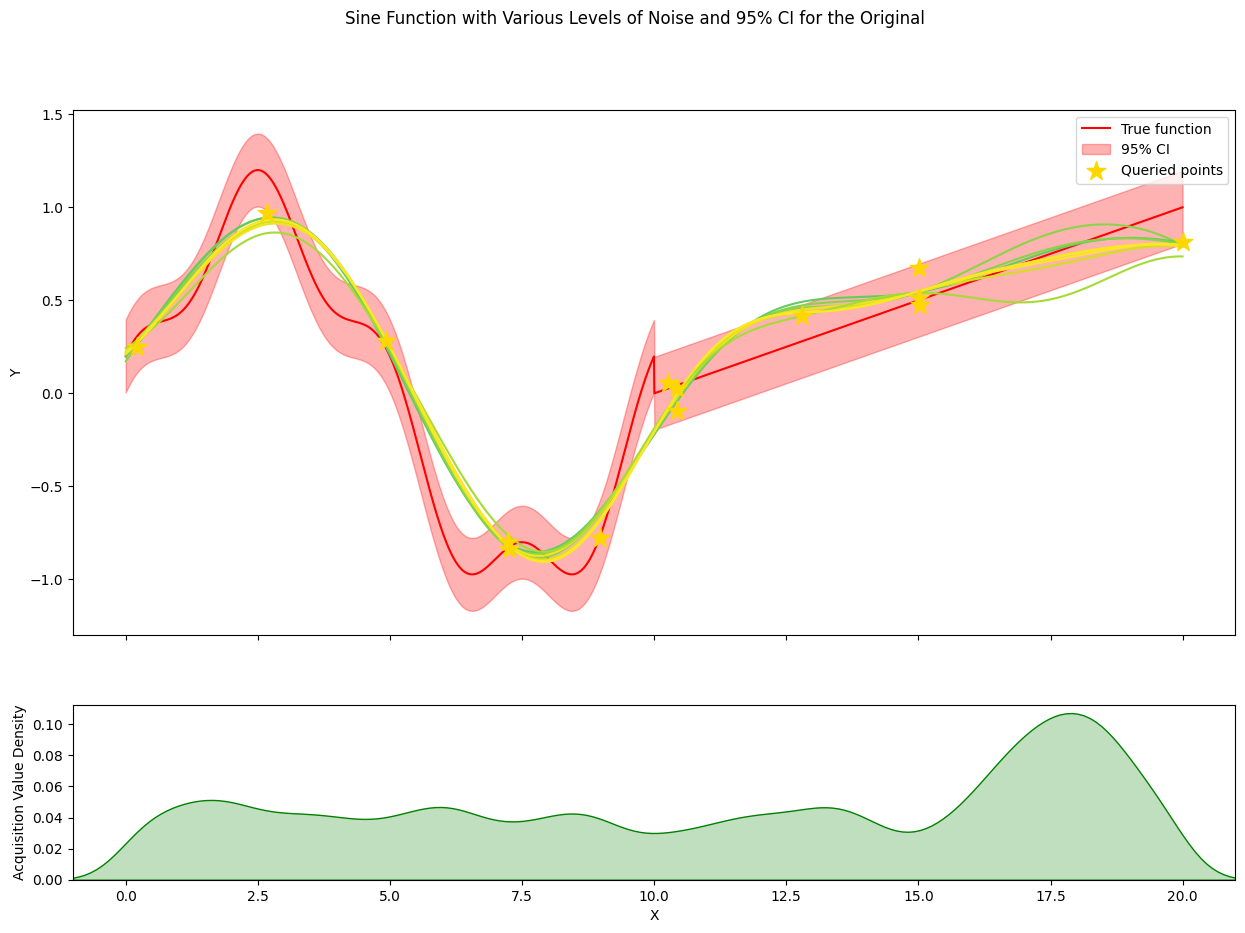

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

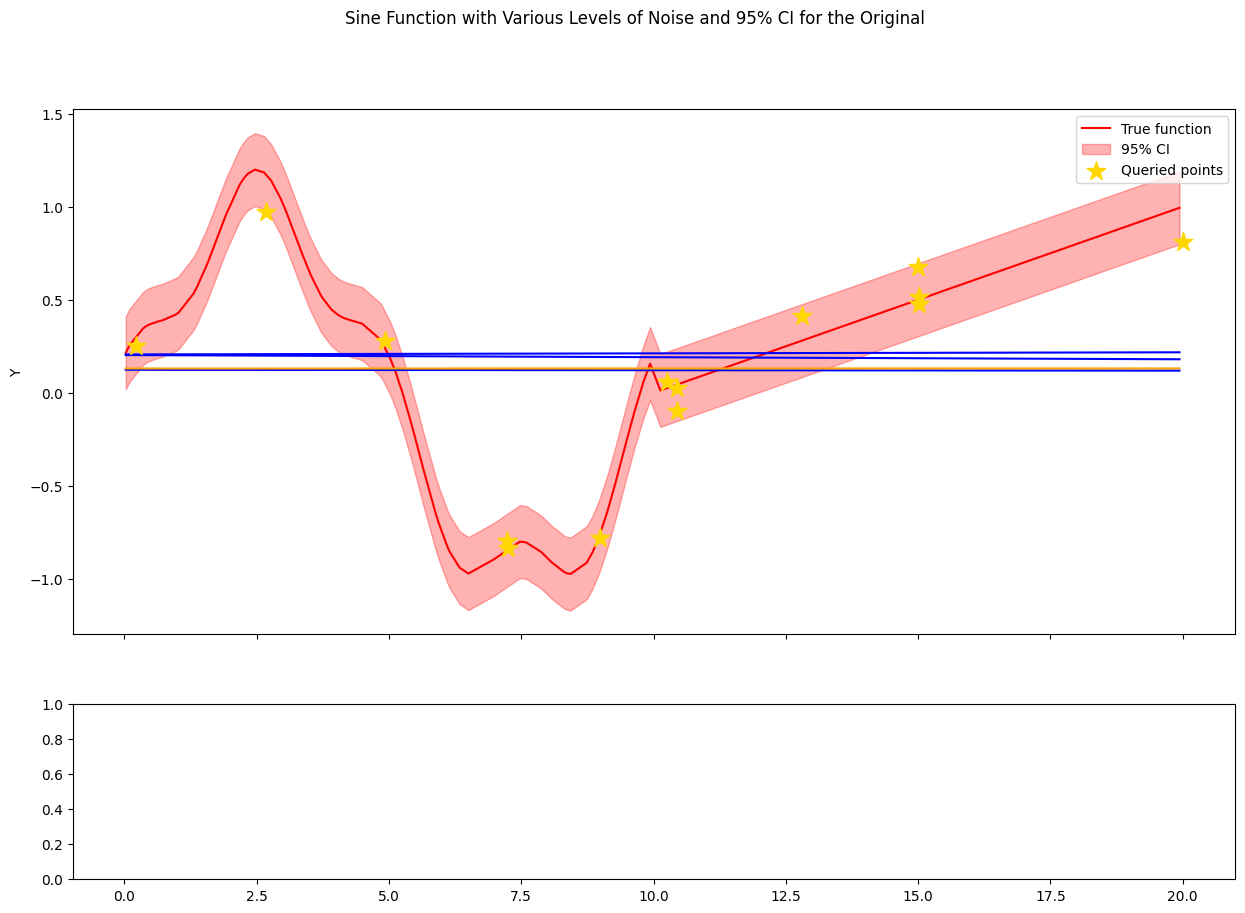

tensor([[0.0189],
        [0.0237],
        [0.0396],
        ...,
        [0.0304],
        [0.0309],
        [0.0410]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0333], dtype=torch.float64), 'lengthscale': tensor([[0.1133]], dtype=torch.float64), 'outputscale': tensor([0.9179], dtype=torch.float64), 'mean': tensor([0.2313], dtype=torch.float64)}


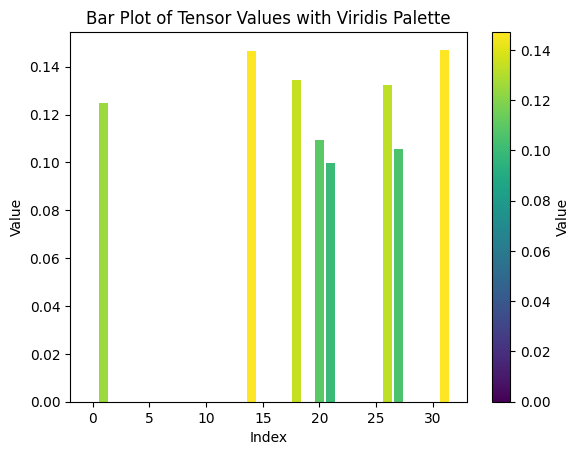

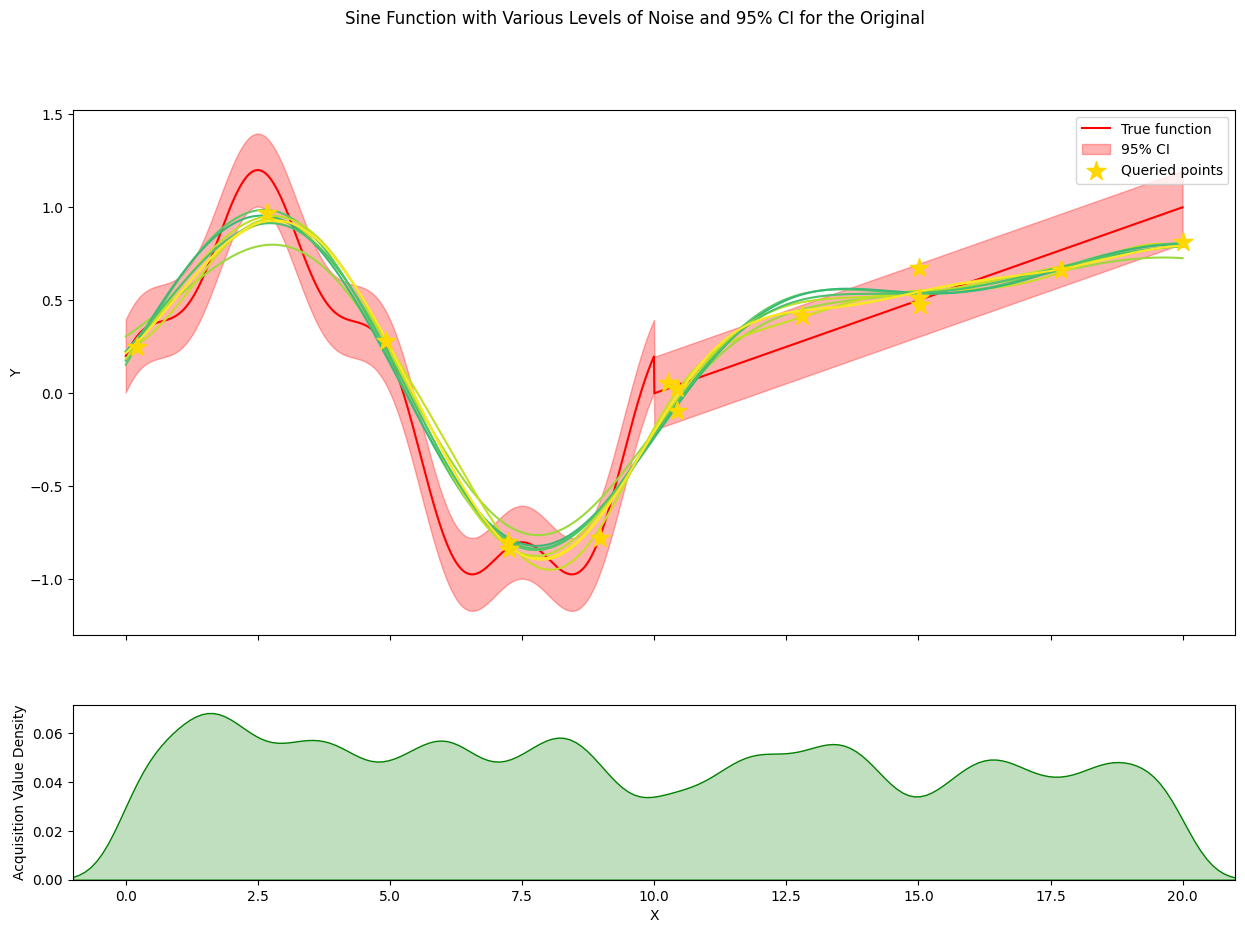

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

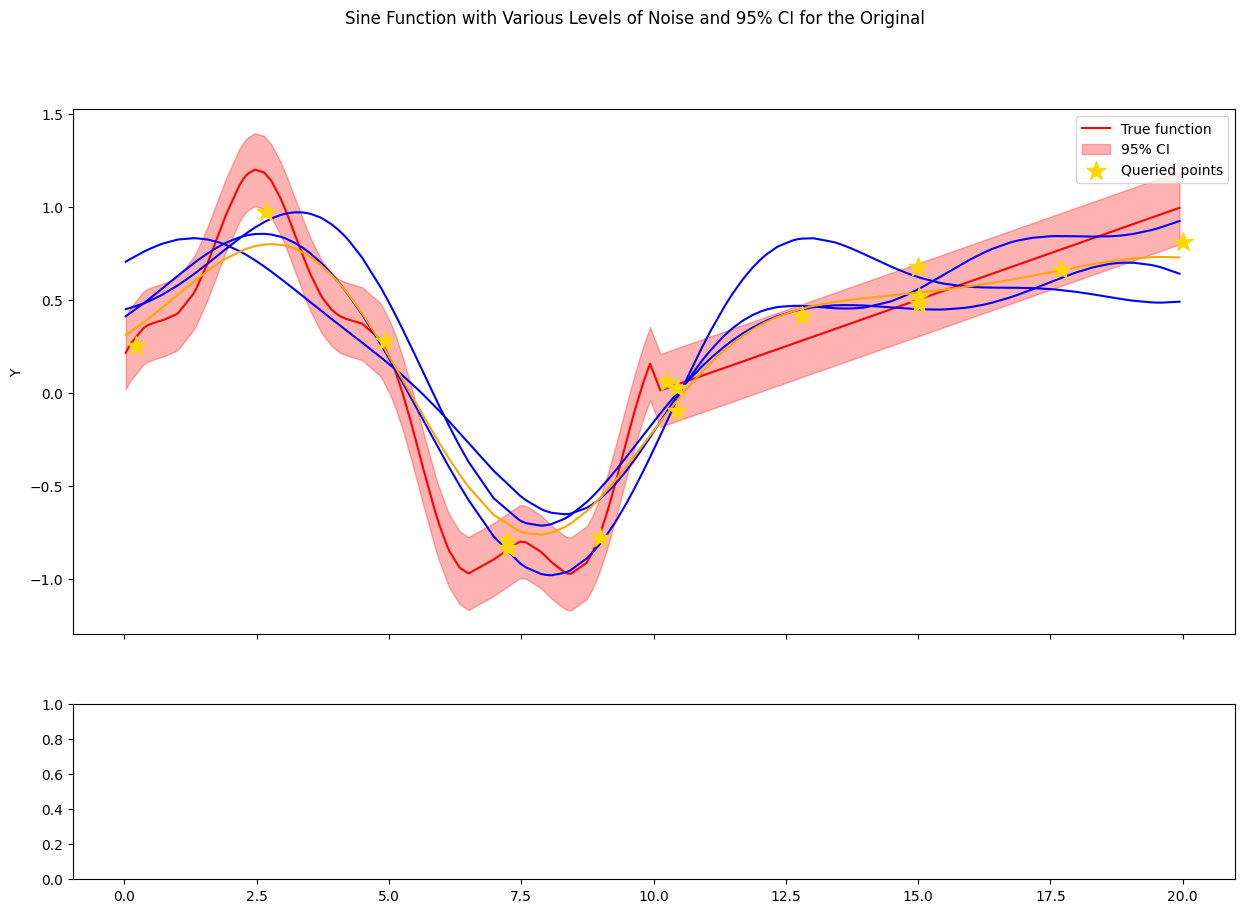

tensor([[0.0298],
        [0.0326],
        [0.0731],
        ...,
        [0.0494],
        [0.0625],
        [0.0468]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0350], dtype=torch.float64), 'lengthscale': tensor([[0.1146]], dtype=torch.float64), 'outputscale': tensor([0.9142], dtype=torch.float64), 'mean': tensor([0.2013], dtype=torch.float64)}


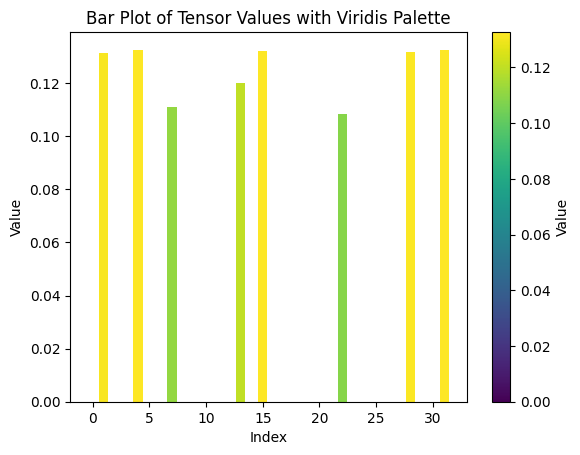

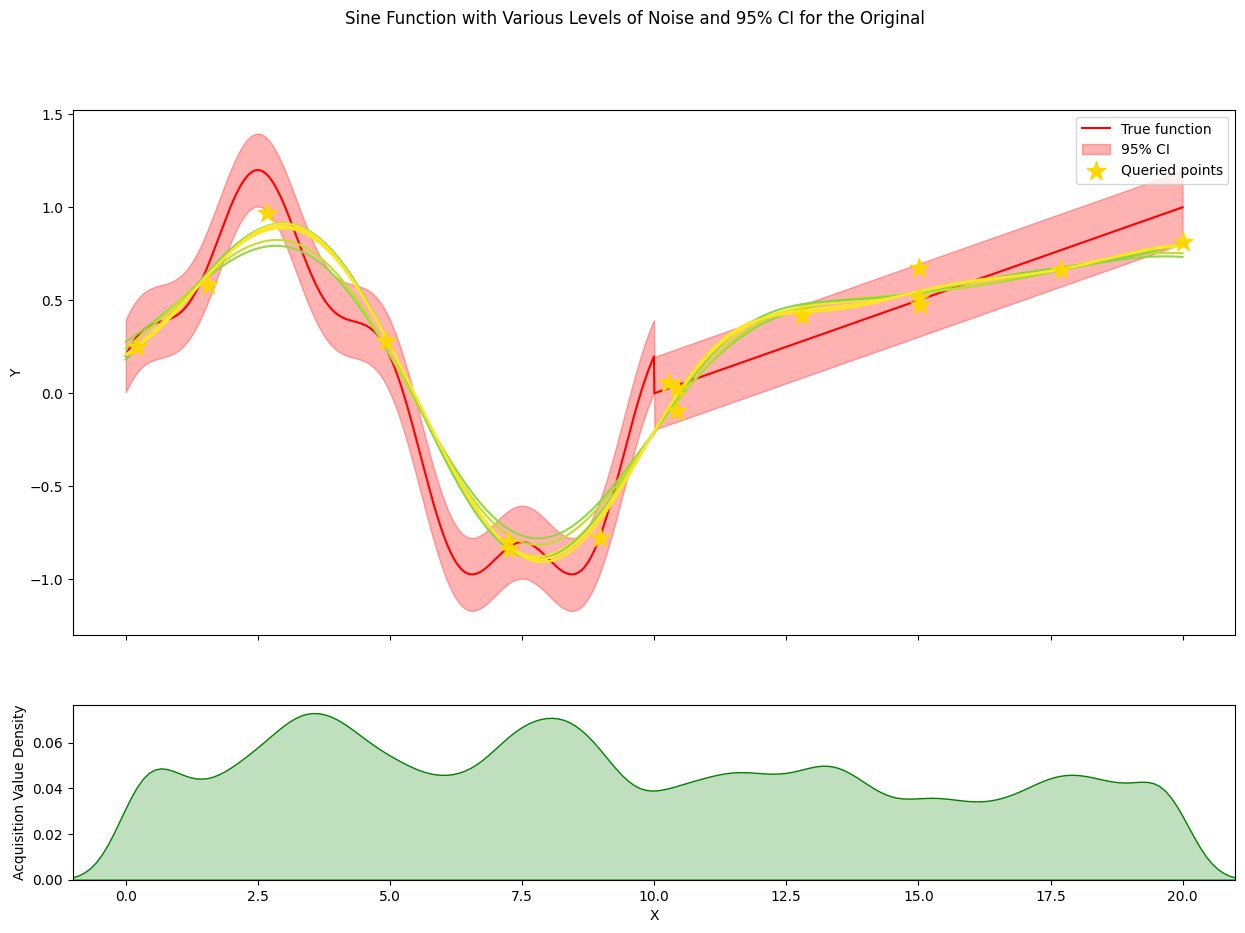

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

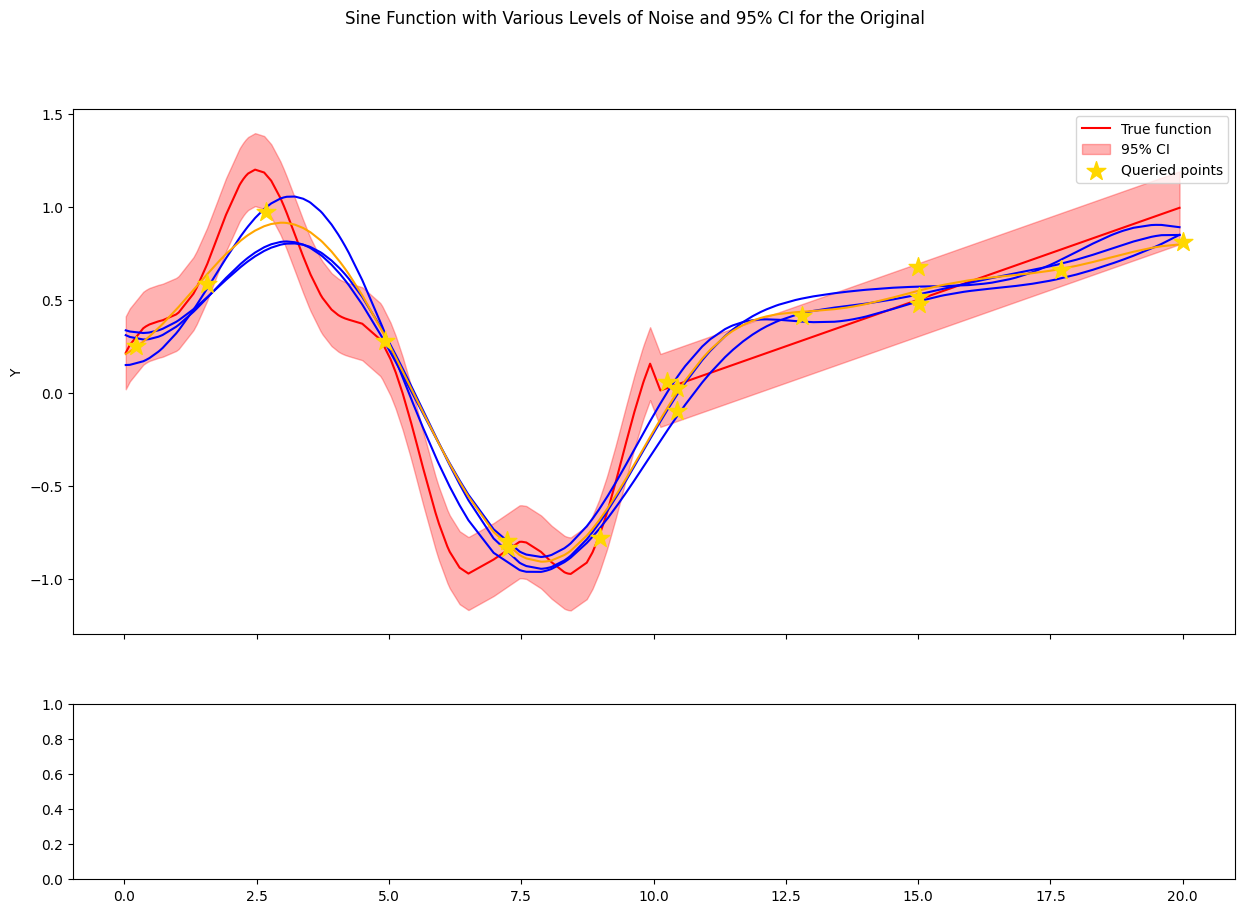

tensor([[0.0211],
        [0.0233],
        [0.0273],
        ...,
        [0.0366],
        [0.0482],
        [0.0346]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0353], dtype=torch.float64), 'lengthscale': tensor([[0.1176]], dtype=torch.float64), 'outputscale': tensor([0.9216], dtype=torch.float64), 'mean': tensor([0.1271], dtype=torch.float64)}


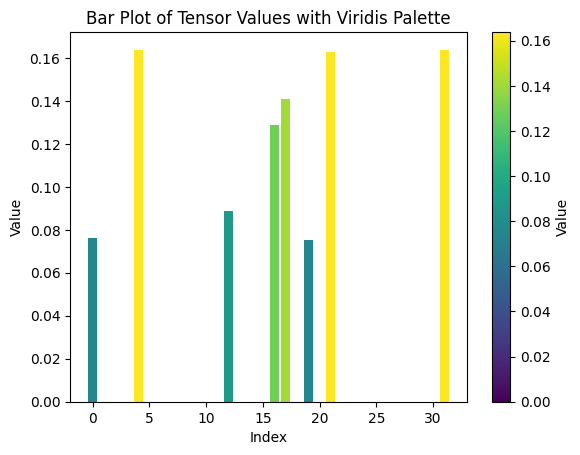

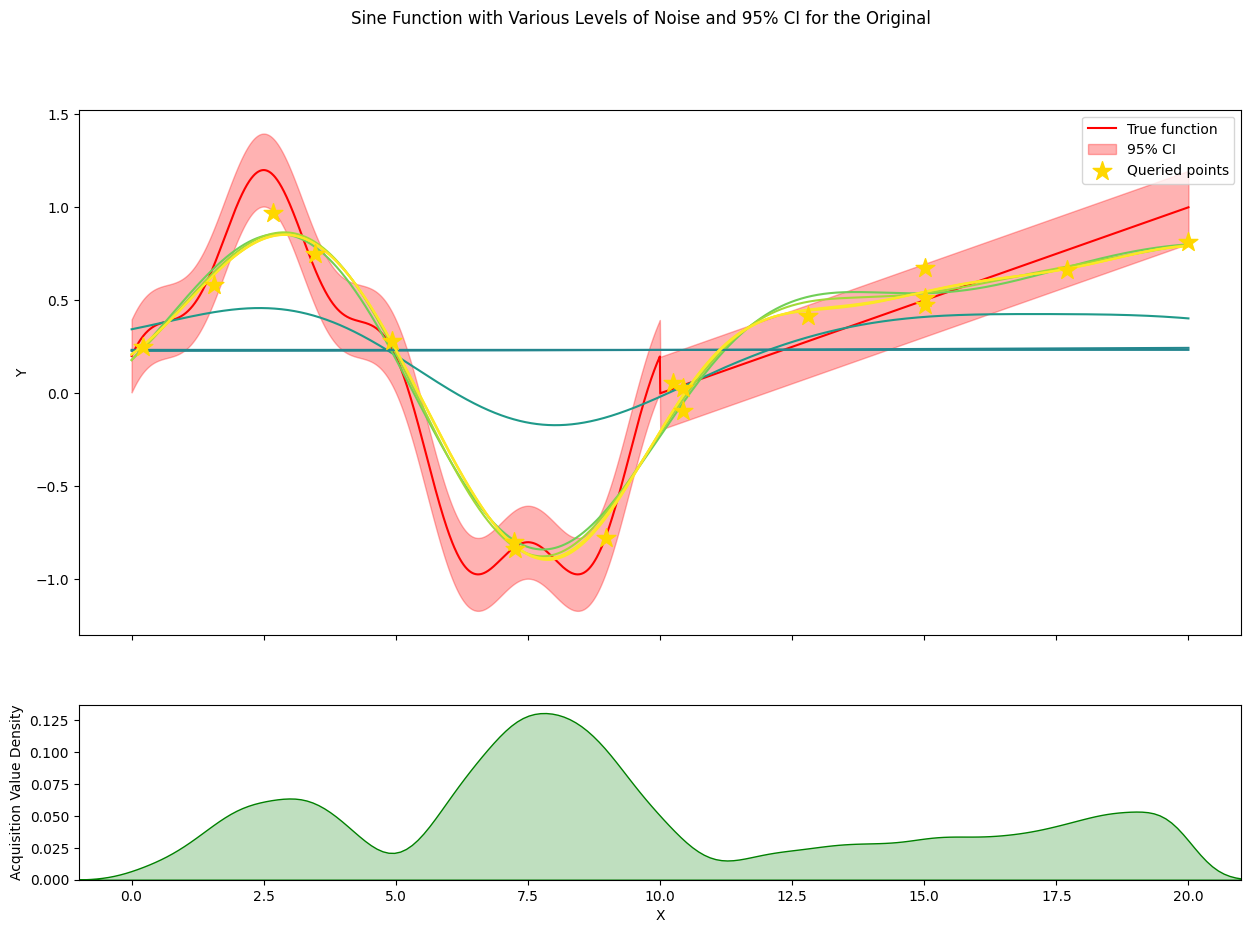

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

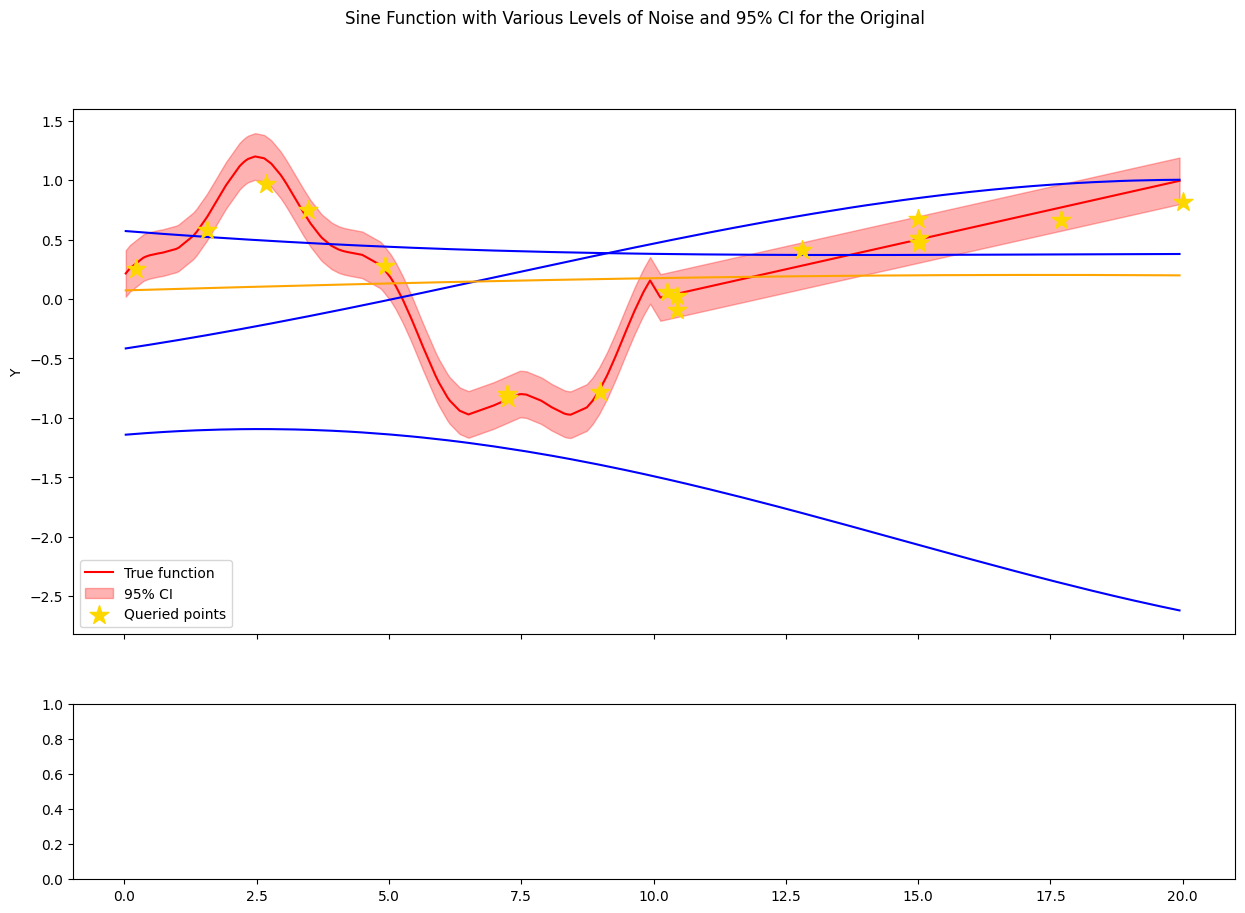

tensor([[0.2283],
        [0.1467],
        [0.2227],
        ...,
        [0.0385],
        [0.5891],
        [0.2656]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0276], dtype=torch.float64), 'lengthscale': tensor([[0.1172]], dtype=torch.float64), 'outputscale': tensor([0.8007], dtype=torch.float64), 'mean': tensor([0.2217], dtype=torch.float64)}


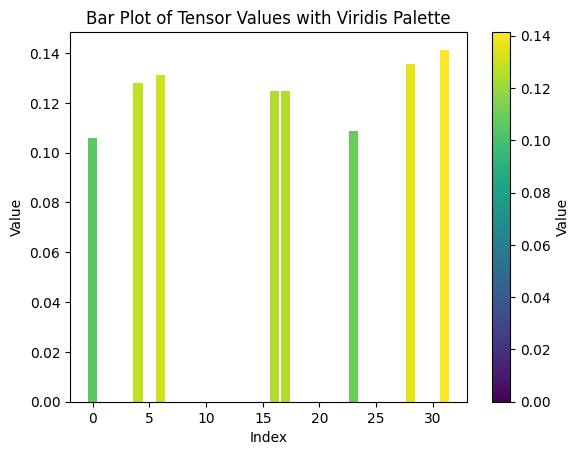

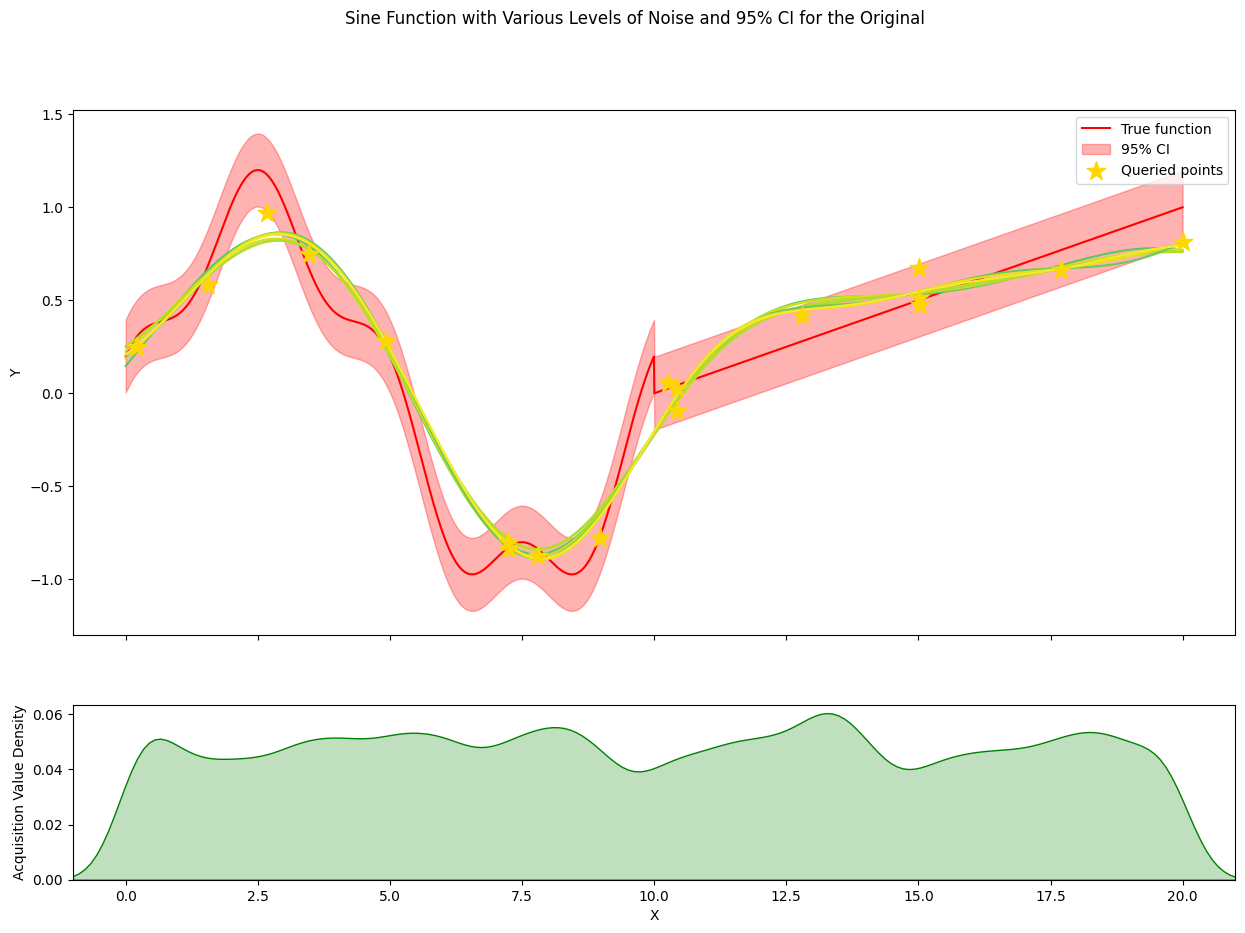

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

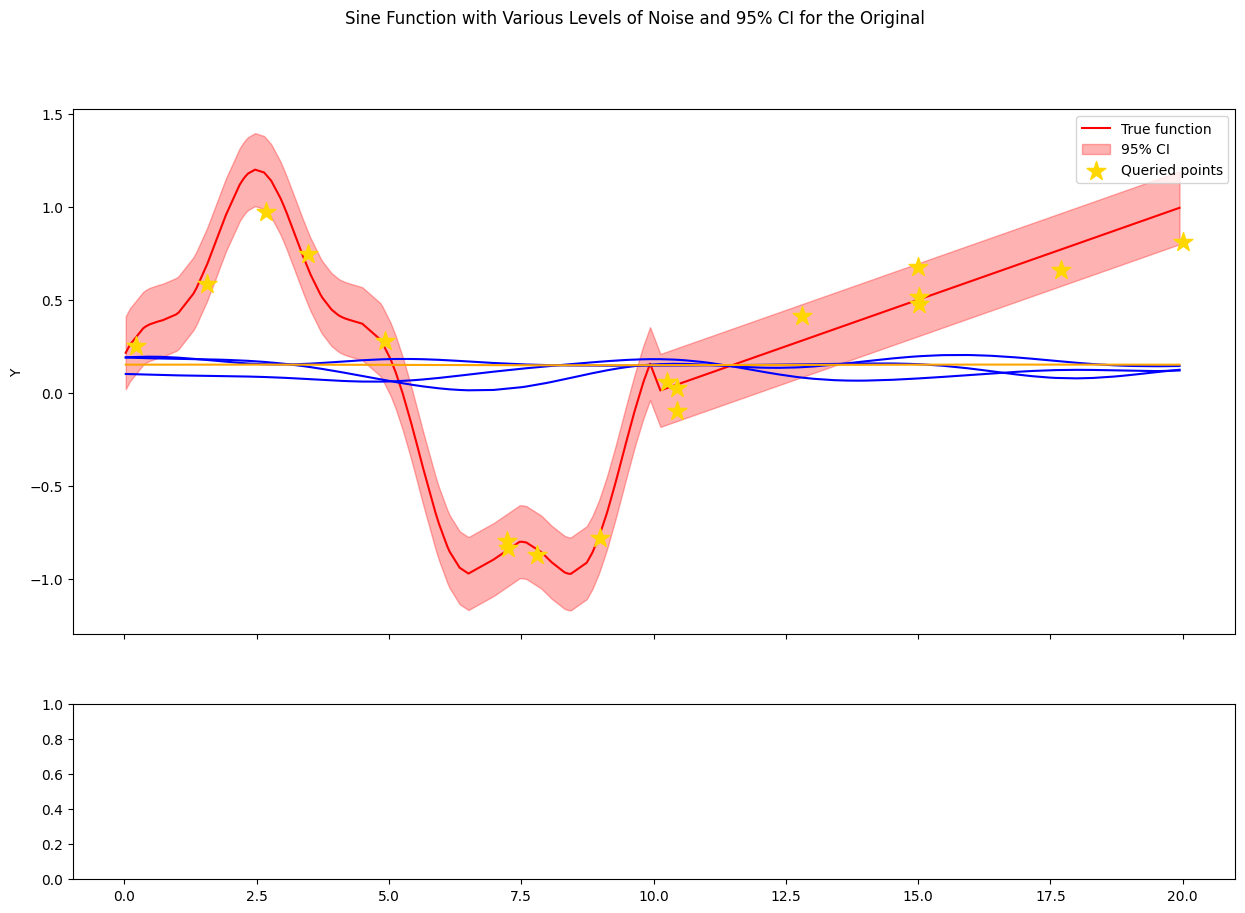

tensor([[0.0183],
        [0.0214],
        [0.0215],
        ...,
        [0.0283],
        [0.0292],
        [0.0271]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0263], dtype=torch.float64), 'lengthscale': tensor([[0.1170]], dtype=torch.float64), 'outputscale': tensor([0.8508], dtype=torch.float64), 'mean': tensor([0.2201], dtype=torch.float64)}


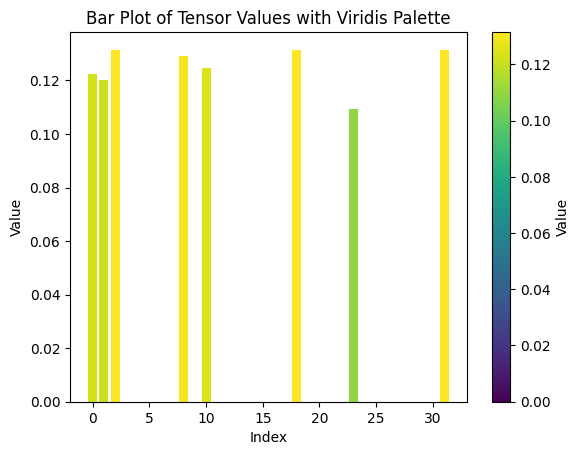

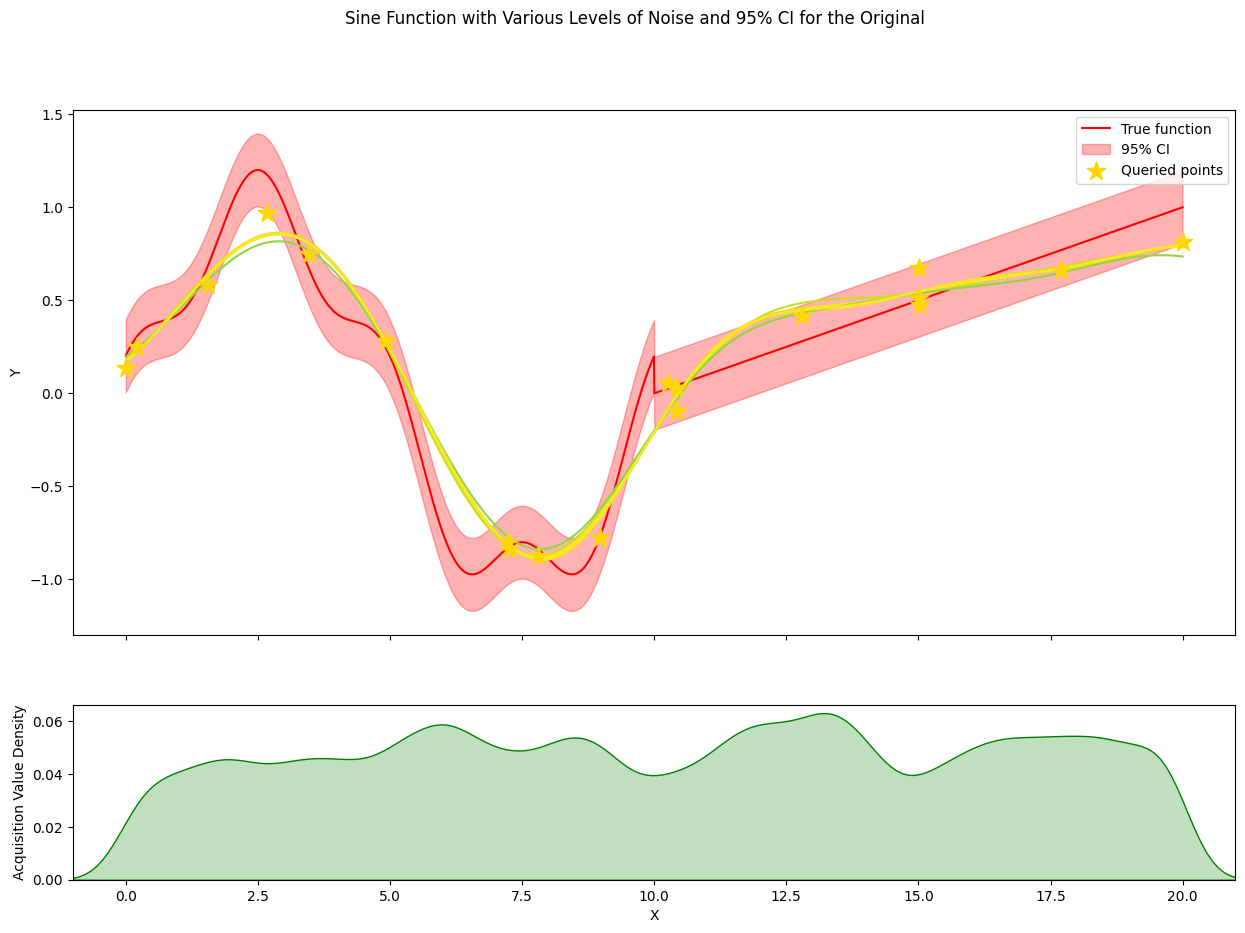

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

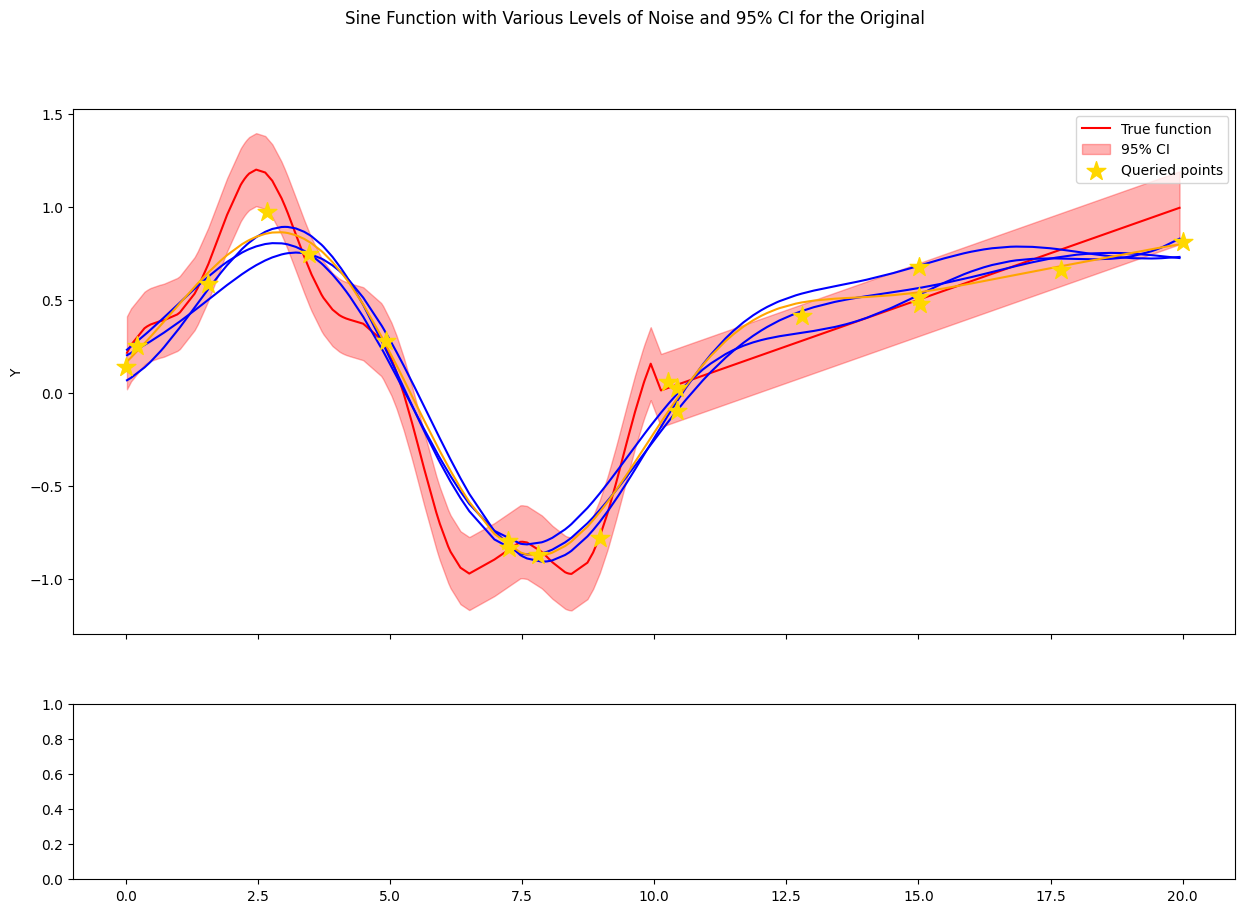

tensor([[0.0134],
        [0.0157],
        [0.0179],
        ...,
        [0.0203],
        [0.0199],
        [0.0219]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0246], dtype=torch.float64), 'lengthscale': tensor([[0.1160]], dtype=torch.float64), 'outputscale': tensor([0.8450], dtype=torch.float64), 'mean': tensor([0.1708], dtype=torch.float64)}


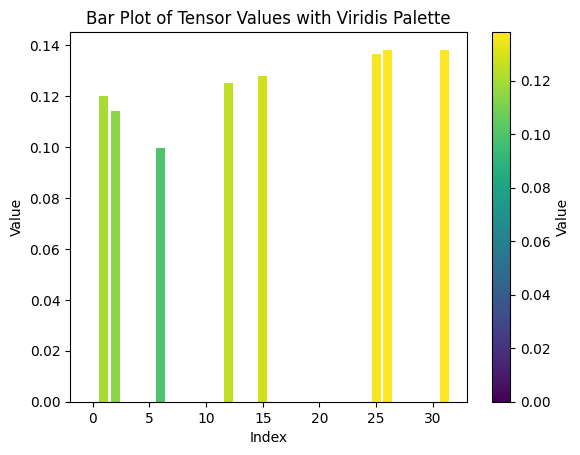

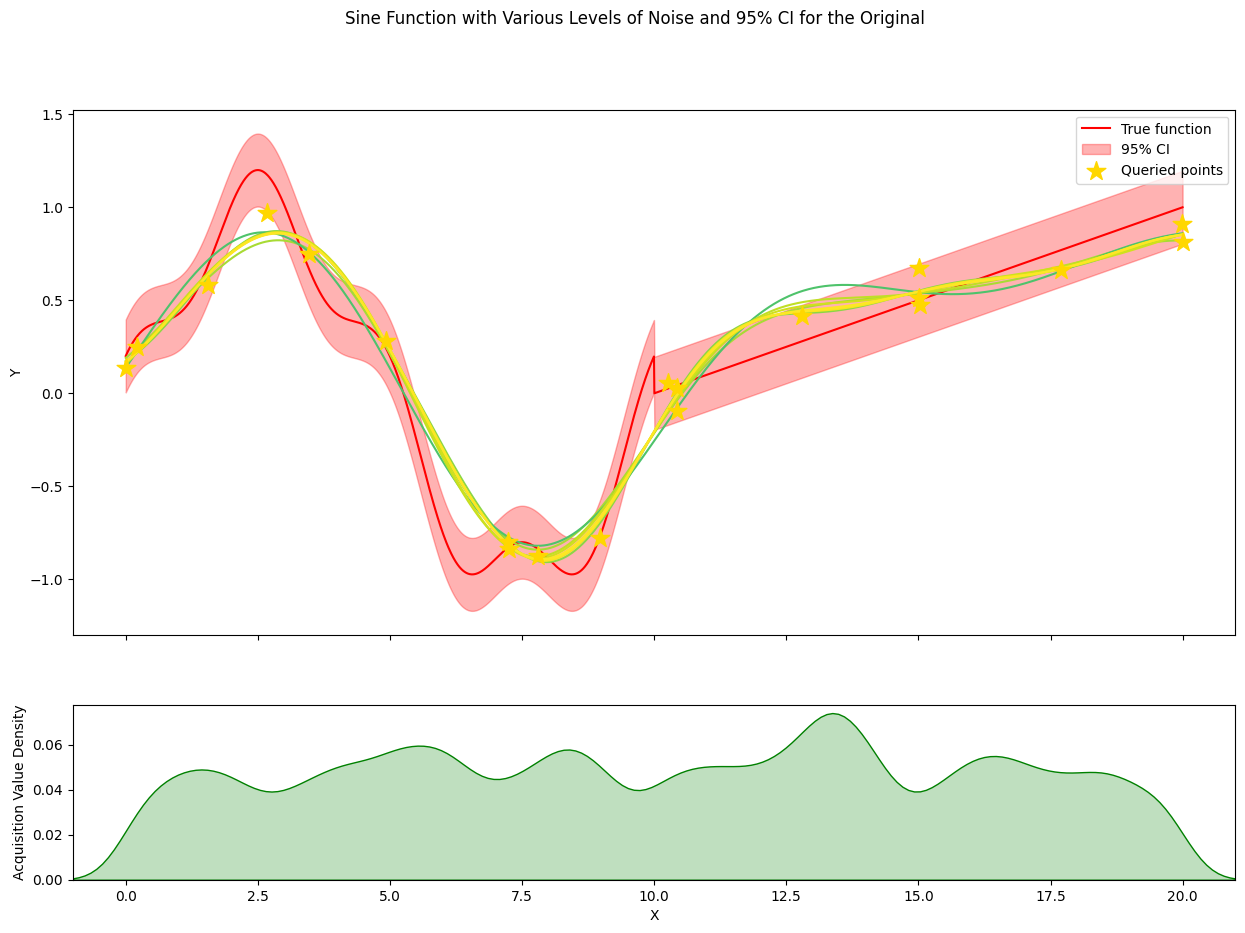

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

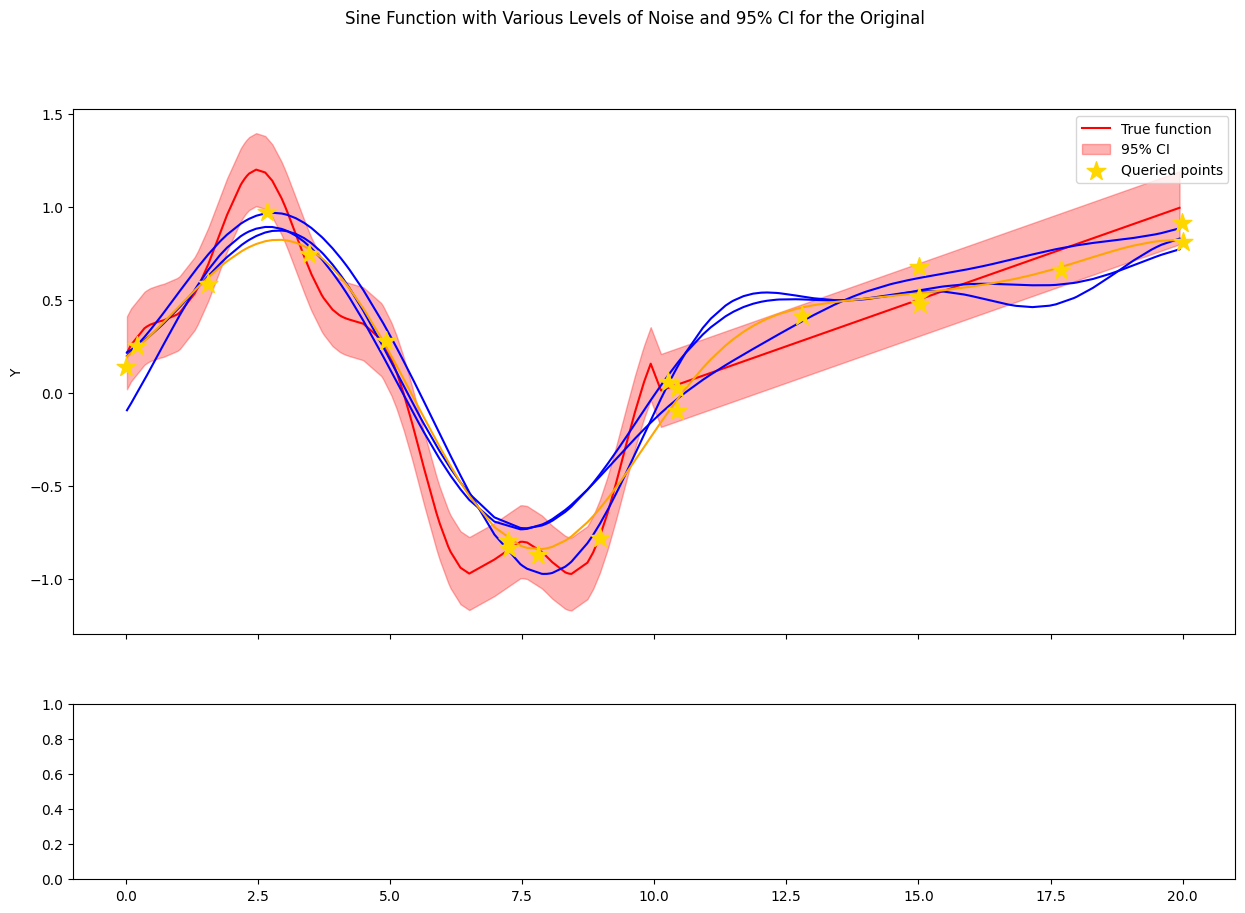

tensor([[0.0200],
        [0.0224],
        [0.0280],
        ...,
        [0.0345],
        [0.0331],
        [0.0226]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0266], dtype=torch.float64), 'lengthscale': tensor([[0.1069]], dtype=torch.float64), 'outputscale': tensor([0.8423], dtype=torch.float64), 'mean': tensor([0.1619], dtype=torch.float64)}


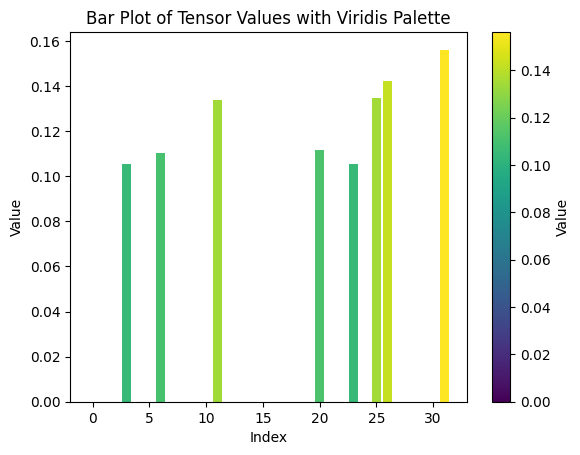

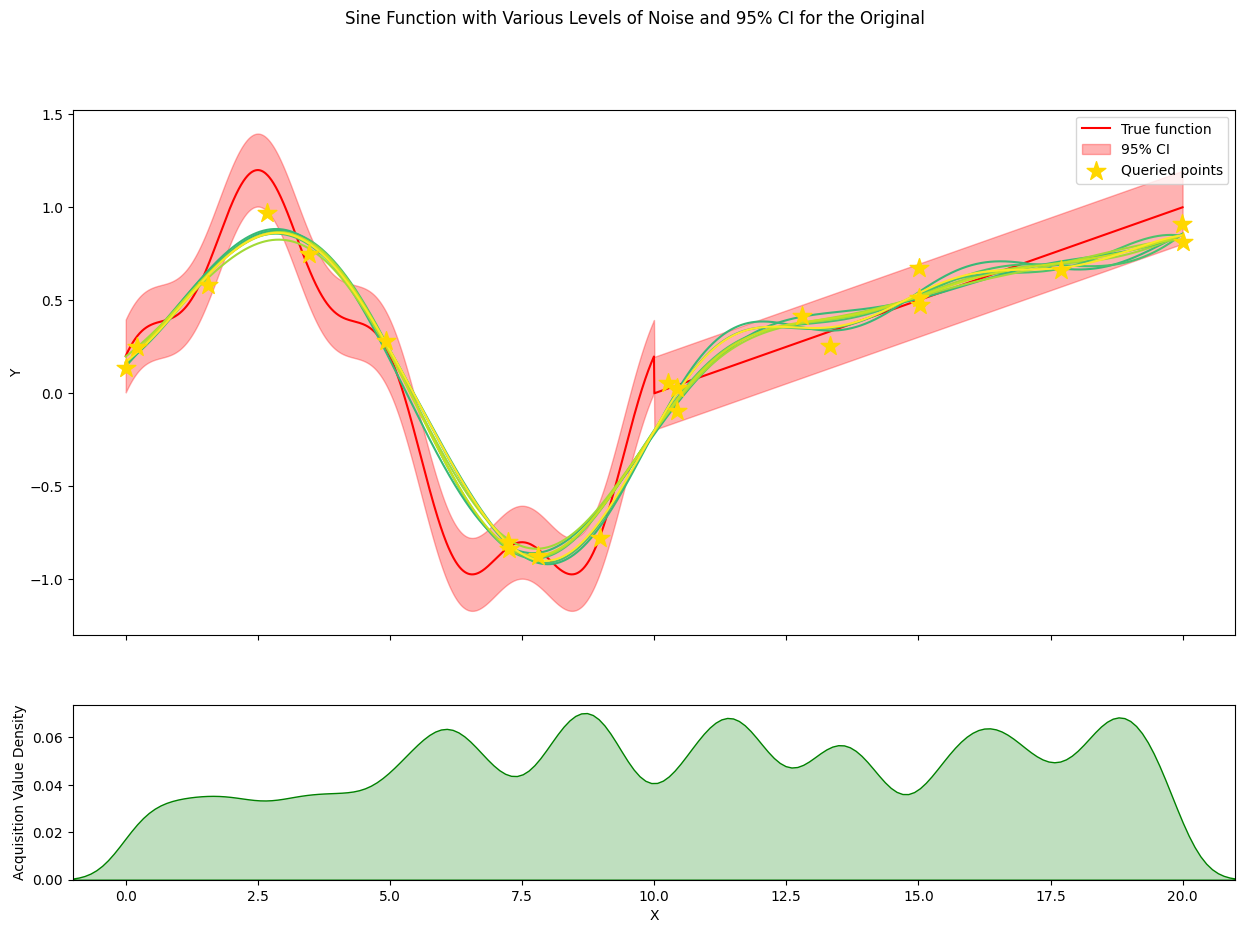

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

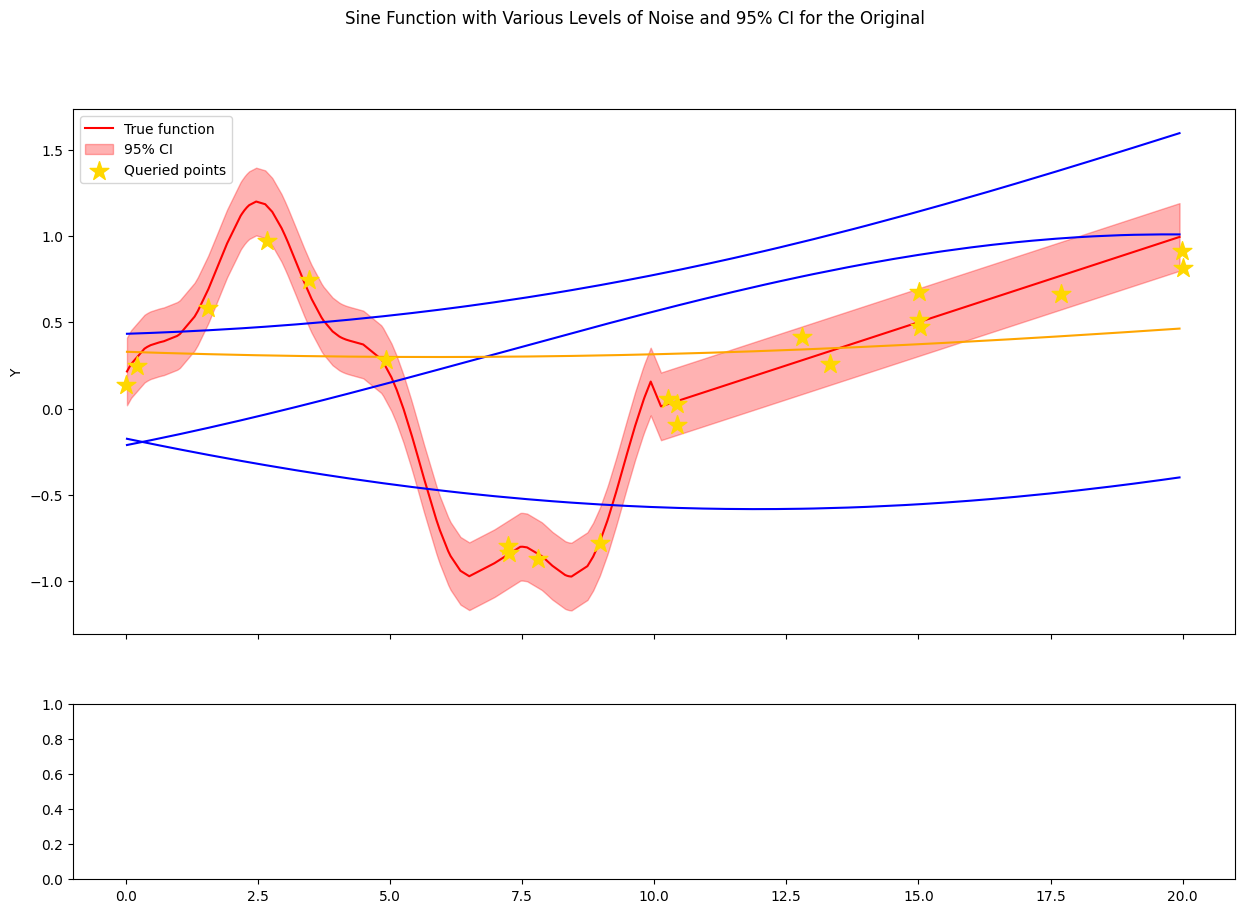

tensor([[0.0161],
        [0.0273],
        [0.0215],
        ...,
        [0.0279],
        [0.0335],
        [0.0317]], dtype=torch.float64, grad_fn=<SumBackward1>)
{'noise': tensor([0.0273], dtype=torch.float64), 'lengthscale': tensor([[0.1031]], dtype=torch.float64), 'outputscale': tensor([0.7756], dtype=torch.float64), 'mean': tensor([0.0753], dtype=torch.float64)}


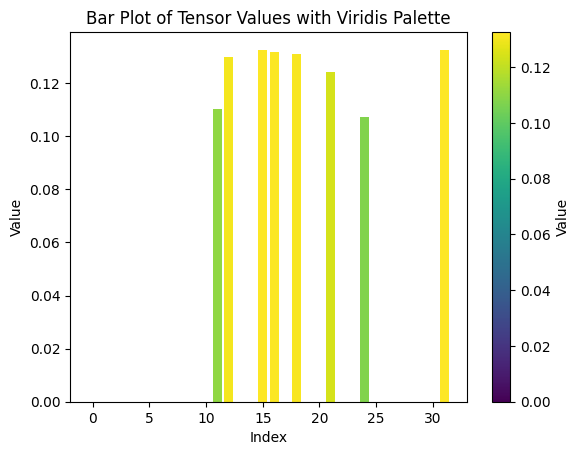

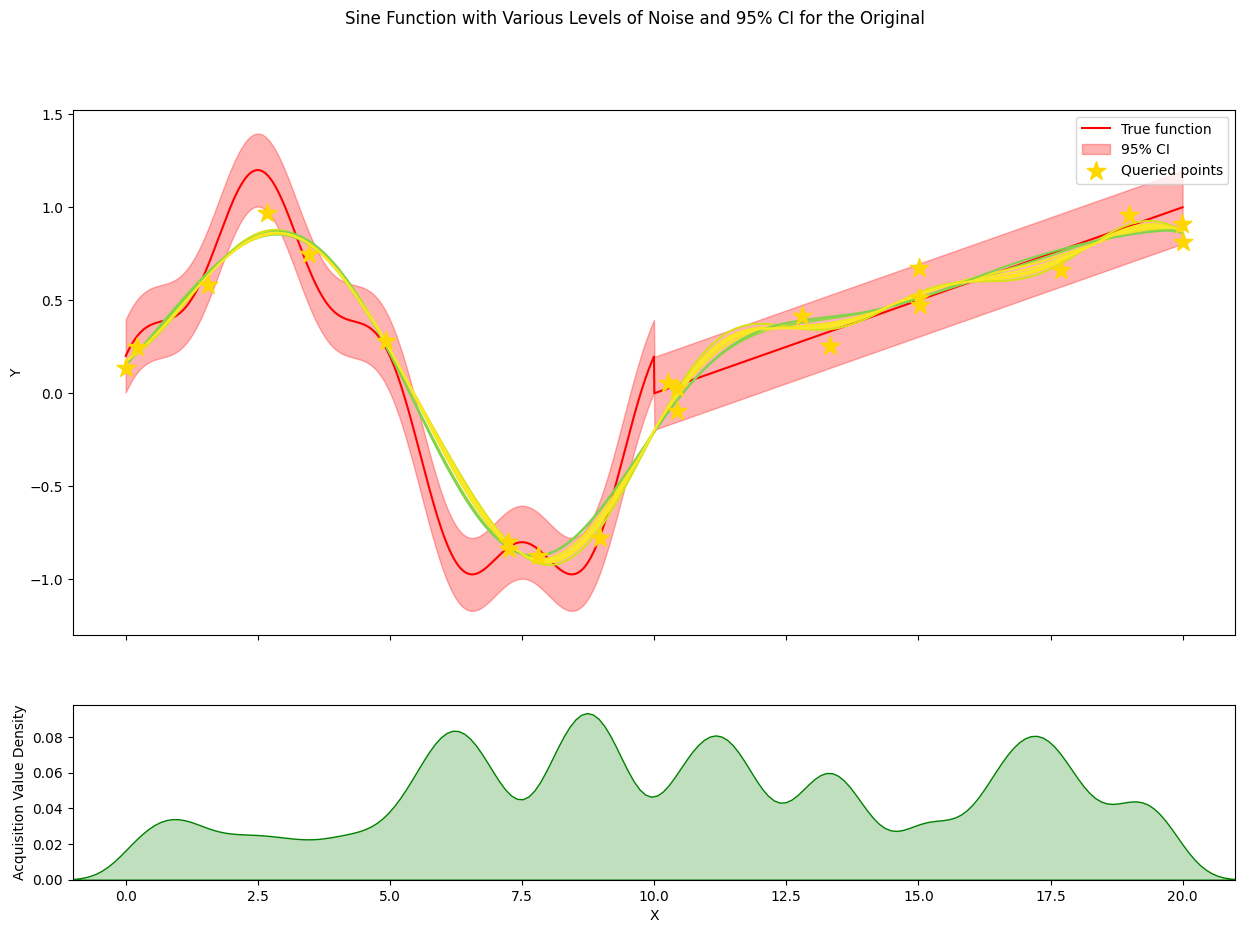

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323],
        [0.3489],
        [0.4017],
        [0.0223],
        [0.1689],
        [0.2939],
        [0.5185],
        [0.6977],
        [0.8000],
        [0.1610],
        [0.2823],
        [0.6816],
        [0.9152],
        [0.3971],
        [0.8742],
        [0.4194],
        [0.5529],
        [0.9527],
        [0.0362],
        [0.1852],
        [0.3734],
        [0.3051],
        [0.9320],
        [0.1759],
        [0.2698],
        [0.1507],
        [0.0317],
        [0.2081],
        [0.9298],
        [0.7231],
        [0.7423],
        [0.5263],
        [0.2437],
        [0.5846],
        [0.0332],
        [0.1387],
        [0.2422],
        [0.8155],
        [0.7932],
        [0.2783],
        [0.4820],
        [0.8198],
        [0.9971],
        [0.6984],
        [0.5675],
        [0.8352],
        [0

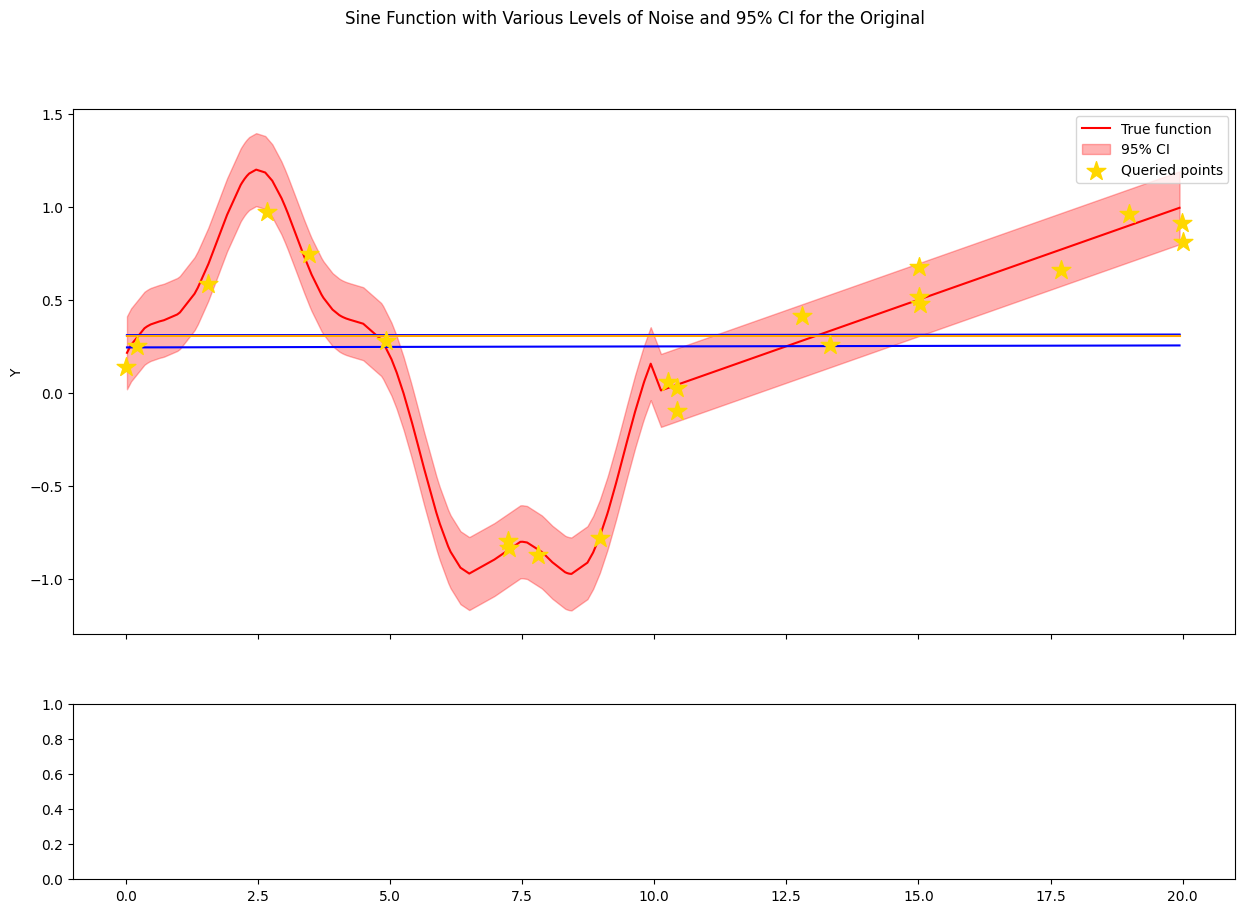

tensor([[0.0052],
        [0.0095],
        [0.0061],
        ...,
        [0.0094],
        [0.0169],
        [0.0122]], dtype=torch.float64, grad_fn=<SumBackward1>)


In [102]:
import matplotlib.pyplot as plt
synthetic_function = Higdon(noise_std=0.1).to(**tkwargs)
bounds = BOUNDS
    #print(bounds)
X = SobolEngine(dimension=DIM, scramble=True, seed=99).draw(3).to(**tkwargs)
    #print(X)
X_scaled = convert_bounds(X, BOUNDS, DIM)
Y = synthetic_function(X_scaled).unsqueeze(-1)
poolU = get_candidate_pool(dim=DIM, bounds=BOUNDS, size=10000).to(**tkwargs)
ewig_pool = poolU.clone()
X_test, Y_test = get_test_set(synthetic_function=synthetic_function, 
                                  bounds=bounds, 
                                  dim=DIM, 
                                  noise_std=0.1,
                                  size=10000)  
     
X_test, Y_test = X_test.to(**tkwargs), Y_test.to(**tkwargs)
dict_best_params = None
for i in range(20):
    train_Y = Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        #input_transform=Normalize(d=cfg.functions.dim, bounds=bountensor_scaledds),
        outcome_transform=Standardize(m=1)
    )
    if type == 'part_bayesian':
        ll = fit_partially_bayesian_mgp_model(model=gp,
                                                num_samples= 32,
                                                lr=0.1,
                                                learning_steps=50,
                                                print_iter=False,
                                                plot=False, 
                                                dict_params=dict_best_params)
        dict_best_params = get_best_model_params(gp, ll=ll)
        print(dict_best_params)
    else:
        ll = fit_fully_bayesian_mgp_model_nuts(gp,
                                            warmup_steps=256,
                                            num_samples=128 ,
                                            thinning=6,
                                            disable_progbar=False)
    acq_function = SALWassersteinMMAcquisitionFunction(gp, ll=ll)
    if ll is not None:
        ll = ll.detach()
        likelihoods = ll.exp()
        median_val = np.percentile(likelihoods, 75)
        #print(median_val)

        likelihoods[likelihoods < median_val] = 0
        weights = likelihoods.pow(1).squeeze().div(likelihoods.pow(1).sum())
        npll = weights.numpy()
        norm = plt.Normalize(npll.min(), npll.max())
        colors = plt.cm.viridis(norm(npll))

    # Generate a sequence of colors from the 'viridis' colormap

    # Plotting
        plt.bar(range(len(npll)), npll, color=colors)
        plt.ylabel('Value')
        plt.xlabel('Index')
        plt.title('Bar Plot of Tensor Values with Viridis Palette')
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), label='Value')
        plt.show()
    else:
        weights = ll

    acq_values = acq_function(poolU)
    acq_values_all = acq_function(ewig_pool)
    best_index = torch.argmax(acq_values)
    candidates = poolU[best_index].unsqueeze(-1)
    new_pool = torch.cat((poolU[:best_index], poolU[best_index + 1:]), dim=0)
    candidates, best_acq_value, poolU = candidates.T, acq_values[best_index].unsqueeze(-1), new_pool

    candidates_scaled = convert_bounds(candidates, BOUNDS, DIM)
    y_hat = get_yhat(gp, X_test, tkwargs)
    plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y,acq_values_all, weights)
    path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([3]))
    reduced_X_test = X_test[:200]
    print(reduced_X_test)
    y_hat = get_yhat(gp, reduced_X_test, tkwargs)
    plot_samples_gp(reduced_X_test, 0.1, synthetic_function, y_hat,path(reduced_X_test),1, X, Y)
    Y_next = synthetic_function(candidates_scaled).unsqueeze(-1)
    if DIM ==1:
        Y_next=Y_next.unsqueeze(-1)
    Y = torch.cat((Y, Y_next)).to(**tkwargs)
    X = torch.cat((X, candidates)).to(**tkwargs)
    print(acq_values)

In [13]:
y_hat.size()


torch.Size([16, 200, 1])

In [14]:
y_hat.size()

torch.Size([16, 200, 1])

In [103]:
class BatchGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, dimensions,  batch_size):
        likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([batch_size]))
        super(BatchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([batch_size]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=dimensions, 
                                       batch_shape=torch.Size([batch_size])),
            batch_shape=torch.Size([batch_size])
        )
    
    def forward(self, x):
        # x is expected to be of shape [batch size, number of data points, features]
        # Ensure that the kernel can handle multidimensional input properly
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def load_params(self, param_dict):
        self.covar_module.base_kernel.lengthscale = param_dict['lengthscale']
        self.covar_module.outputscale = param_dict['outputscale']
        self.mean_module.constant = param_dict['mean']
        self.likelihood.noise_covar.noise = param_dict['noise']
        
        



In [104]:
path = botorch.sampling.pathwise.posterior_samplers.draw_matheron_paths(gp, torch.Size([3]))

In [17]:
path(torch.Tensor([[0.5]]))

tensor([[[ 0.0293],
         [ 0.0650],
         [-0.1475],
         [-0.1880],
         [ 0.0233],
         [-0.7231],
         [-0.0051],
         [ 0.1321],
         [ 0.0949],
         [ 0.1694],
         [ 0.1596],
         [ 0.0706],
         [ 0.0581],
         [ 0.0192],
         [ 0.1592],
         [-0.0090]],

        [[ 0.0953],
         [ 0.0115],
         [-0.1786],
         [ 0.0772],
         [ 0.0472],
         [ 1.3477],
         [ 0.0075],
         [ 0.1586],
         [ 0.0361],
         [ 0.1808],
         [ 0.1537],
         [ 0.0373],
         [ 0.1046],
         [ 0.0122],
         [ 0.1524],
         [ 0.1128]],

        [[ 0.1330],
         [ 0.0409],
         [-0.1408],
         [-0.3533],
         [ 0.0398],
         [ 3.6519],
         [ 0.0997],
         [ 0.1406],
         [ 0.2271],
         [ 0.1723],
         [ 0.1612],
         [ 0.2175],
         [ 0.1150],
         [ 0.0180],
         [ 0.1365],
         [-0.1068]]], dtype=torch.float64, grad_fn=<Sque

In [105]:
samples =path(X_test[:10000])

In [106]:
max_obj = samples.max(dim=2)
del samples 
maximun_index = max_obj[1]
maximuns = max_obj[0]

In [107]:
X_to_condition = X_test[maximun_index]

In [108]:
index = 0
X_to_condition= X_to_condition[index, :,:].unsqueeze(1)

In [109]:
Y_to_condition = maximuns[index].unsqueeze(1)

In [23]:
maximuns.size()

torch.Size([3, 16])

In [110]:
batch_gp = BatchGPModel(torch.cat([X.repeat(32,1,1), X_to_condition], dim=1),
             torch.cat([Y.repeat(32,1,1).squeeze(), Y_to_condition], dim=1),
             dimensions=DIM,
             batch_size=32)
batch_gp.load_params(gp.get_param_dict())

In [112]:
maxs = maximuns[index].unsqueeze(1).repeat(1, 10000).detach()

In [114]:
batch_gp.eval()
batch_gp.likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # The test data is wrapped in a torch.no_grad() context
    # to indicate that we do not need gradients
    # gpytorch.settings.fast_pred_var() is used to speed up predictions
 # Add batch dimension if your model expects it
    predictions = batch_gp.likelihood(batch_gp(X_test))

    # Extract mean and variance
    means = predictions.mean
    variances = predictions.variance

In [126]:
Norm = torch.distributions.normal.Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
#https://en.wikipedia.org/wiki/Truncated_normal_distribution
pdf_betas=Norm.log_prob(maxs).exp()
cdf_betas = Norm.cdf(maxs)
tnorm_mean = means -variances.pow(-2)*pdf_betas.div(cdf_betas)
print(variances.pow(-2)*pdf_betas.div(cdf_betas))
right = -pdf_betas.div(cdf_betas)
right = right.pow(2)
left = maxs*pdf_betas.div(cdf_betas) 
tnorm_var = 1-left-right
tnorm_var = variances*tnorm_var

tensor([[8.9045e-06, 8.9045e-06, 8.9045e-06,  ..., 8.9045e-06, 8.9045e-06,
         8.9045e-06],
        [1.8132e-05, 1.8132e-05, 1.8132e-05,  ..., 1.8132e-05, 1.8132e-05,
         1.8132e-05],
        [6.3540e-01, 6.3539e-01, 6.3539e-01,  ..., 6.3539e-01, 6.3540e-01,
         6.3539e-01],
        ...,
        [7.0183e-02, 6.7590e-02, 6.5338e-02,  ..., 6.8476e-02, 6.9963e-02,
         6.2701e-02],
        [9.5834e-01, 9.3353e-01, 8.6732e-01,  ..., 9.2606e-01, 9.5217e-01,
         8.5781e-01],
        [2.4418e+02, 1.8866e+02, 1.5722e+02,  ..., 1.2171e+02, 2.4284e+02,
         2.3688e+02]], dtype=torch.float64)


In [121]:
means

tensor([[ 0.0827,  0.0827,  0.0826,  ...,  0.0826,  0.0827,  0.0828],
        [ 0.1077,  0.1077,  0.1077,  ...,  0.1077,  0.1077,  0.1077],
        [ 0.0697,  0.0697,  0.0696,  ...,  0.0696,  0.0697,  0.0697],
        ...,
        [ 0.1993,  0.2852,  0.0785,  ...,  0.1256,  0.1697,  0.3537],
        [ 0.1151,  0.3076,  0.0481,  ...,  0.0404,  0.0733,  0.5068],
        [-0.2806,  0.5685,  0.7007,  ...,  0.2257, -0.9634,  0.9198]],
       dtype=torch.float64)

In [85]:
batch_gp.train_inputs[0].size()

torch.Size([16, 9, 1])

In [30]:
# Assuming new_x and new_y are your new data points with appropriate batch dimensions
# new_x of shape [Batch, New Points, Features]
# new_y of shape [Batch, New Points]

# Update model with new data (assuming new_x and new_y are tensors with batch dimensions)
gp.set_train_data(inputs=torch.cat([X.repeat(44,1,1), X_to_condition], dim=1), 
                     targets=torch.cat([Y.repeat(44,1,1).squeeze(), Y_to_condition], dim=1), 
                     strict=False)

# Optionally, re-optimize the model parameters here

In [34]:
dictss = gp.get_param_dict()
dictss['noise'].size()

torch.Size([44, 1])

In [ ]:
y_hat = get_yhat(gp, X_test, tkwargs)
y_hat.size()

torch.Size([10, 1000, 100, 1])

In [35]:
posterior = gp.posterior(X_test)
Y_full = posterior.mean

In [36]:
Y_full.size()

torch.Size([44, 44, 10000, 1])

In [62]:
gp.train_targets

tensor([ 0.6783,  0.7889,  0.1905, -0.0765,  0.9319, -0.6050, -1.9081],
       dtype=torch.float64)

In [39]:
Y_full[1,:]

tensor([[[0.3244],
         [0.3244],
         [0.3244],
         ...,
         [0.3244],
         [0.3244],
         [0.3244]],

        [[0.3130],
         [0.4717],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5490]],

        [[0.4137],
         [0.4137],
         [0.4137],
         ...,
         [0.4137],
         [0.4137],
         [0.4137]],

        ...,

        [[0.2992],
         [0.2992],
         [0.2992],
         ...,
         [0.2992],
         [0.2992],
         [0.2992]],

        [[0.3299],
         [0.4626],
         [0.3543],
         ...,
         [0.3134],
         [0.3114],
         [0.5963]],

        [[0.3175],
         [0.4641],
         [0.3250],
         ...,
         [0.2865],
         [0.2904],
         [0.5520]]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [38]:
Y_full[:,1]

tensor([[[0.3130],
         [0.4509],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5147]],

        [[0.3130],
         [0.4717],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5490]],

        [[0.3130],
         [0.4509],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5147]],

        ...,

        [[0.3130],
         [0.4509],
         [0.2905],
         ...,
         [0.2717],
         [0.2728],
         [0.5487]],

        [[0.3130],
         [0.4509],
         [0.2905],
         ...,
         [0.2717],
         [0.2728],
         [0.5487]],

        [[0.3129],
         [0.4427],
         [0.3051],
         ...,
         [0.2718],
         [0.2728],
         [0.5487]]], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [ ]:
y_hat[1,:,:].size()

torch.Size([200, 1])

In [ ]:
Y_full[0,1,:,:]

tensor([[0.4846],
        [0.5124],
        [0.4453],
        ...,
        [0.4607],
        [0.4750],
        [0.5348]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [ ]:
y_hat.size()

torch.Size([10, 1000, 100, 1])

In [ ]:
Y_full[0,1,:,:]

tensor([[0.4846],
        [0.5124],
        [0.4453],
        ...,
        [0.4607],
        [0.4750],
        [0.5348]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [ ]:
y_hat = get_yhat(gp, X_test, tkwargs)
plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y,acq_values_all, weights)

ValueError: Length of values (1000) does not match length of index (10000)

In [ ]:
X_test.size()

torch.Size([10000, 1])

In [ ]:
Y.repeat(22,1,1).size()

torch.Size([22, 93, 1])

In [ ]:
torch.cat([Y.repeat(22,1,1), Y_to_condition], dim=1)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [ ]:
torch.cat([X.repeat(22,1,1), X_to_condition], dim=1)

tensor([[[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [9.9994e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.3738e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [7.9691e-05]],

        ...,

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.3706e-01]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [7.9691e-05]],

        [[1.0616e-02],
         [7.5043e-01],
         [5.2182e-01],
         ...,
         [2.2583e-01],
         [8.9183e-01],
         [1.2266e-01]]], dtype=torch.float64)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_samples_gp(test_X, std, synthetic_function,Y_hat, samples, index, X_train, Y_train):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    samples_selected = samples[:,index,:].detach().numpy()
    df['gp_mean'] = gps_y[index,:]
    gp_cols = ['gp_' + str(i) for i in range(len(samples_selected))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = samples_selected[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)


    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    for i, gp_col in enumerate(gp_cols):
            color = 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='gold', s=200, marker='*', label='Queried points', zorder=5)
    ax1.legend()
    ax1.plot(df.x, df.gp_mean, color='orange')
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

# Example data
train_x = torch.rand(10, 1)  # Feature vector of 10 points
train_y = torch.sin(train_x).squeeze()  # Target vector

# Define GP model
likelihood = GaussianLikelihood()
model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood)

# Model training (for completeness)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
# Here you would optimize the MLL using your choice of optimizer...

# Prepare for sampling
model.eval()  # Put the model in evaluation mode

# Sampling parameters
sample_shape = torch.Size([10])  # For example, draw 10 samples

# Draw samples
samples = draw_matheron_paths(model=model, sample_shape=sample_shape, X=train_x)


AttributeError: 'GaussianLikelihood' object has no attribute 'dim'

In [ ]:
samples[1]

NameError: name 'samples' is not defined

In [ ]:
from scipy import optimize
from scipy import stats
def mode_params(gp):
    model_dict = gp.get_param_dict()
    decomposed_param_dict = {}
    decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
    decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
    for i in range(model_dict['lengthscale'].size()[1]):
        decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()
    decomposed_param_dict['mean']  = model_dict['mean'].numpy()
    df_params = pd.DataFrame(decomposed_param_dict)
    print(df_params.head())
    array_params = df_params.values.T
    kernel = stats.gaussian_kde(array_params)
    print(kernel([0.3,0.1,2,0.3]))
    x0 = np.mean(array_params, axis=1)
    print(x0)
    bounds = [(1e-8, None) for i in range(array_params.shape[0]-1)]
    bounds.append((None,None))
    opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
    return opt

In [ ]:
def get_mode_param_dict(gp):
    model_dict = gp.get_param_dict()
    decomposed_param_dict = {}
    decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
    decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
    for i in range(model_dict['lengthscale'].size()[1]):
        decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()
    decomposed_param_dict['mean']  = model_dict['mean'].numpy()
    df_params = pd.DataFrame(decomposed_param_dict)
    array_params = df_params.values.T
    kernel = stats.gaussian_kde(array_params)
    mode_index = kernel(array_params).argmax()
    mode_df = df_params.iloc[mode_index]
    mode_dict = {}
    lenghtscales = []
    for i in range(model_dict['lengthscale'].size()[1]):
        lenghtscales.append(mode_df['legthscale_'+str(i)])
    mode_dict['lenghtscale'] = torch.Tensor([lenghtscales])
    mode_dict['noise'] = torch.Tensor([mode_df['noise']])
    mode_dict['outputscale'] = torch.Tensor([mode_df['outputscale']])
    mode_dict['mean'] = torch.Tensor([mode_df['mean']])
    return mode_dict

In [ ]:
get_mode_param_dict(gp)

{'lenghtscale': tensor([[0.0260]]),
 'noise': tensor([0.6599]),
 'outputscale': tensor([7.3203]),
 'mean': tensor([0.3864])}

In [ ]:
model_dict = gp.get_param_dict()
decomposed_param_dict = {}

In [ ]:
decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
decomposed_param_dict['mean']  = model_dict['mean'].numpy()


In [ ]:
model_dict['lengthscale'][:,0].squeeze()

tensor([1.6233e-01, 1.1975e+00, 1.9129e-01, 5.9169e+01, 2.5869e+00, 1.5540e-01,
        6.8032e-01, 7.9056e+00, 3.4115e+01, 3.5880e-01, 1.4940e+01, 5.6973e-02,
        1.2637e-01, 1.0570e+00, 4.7083e+02, 6.5810e-01, 2.7366e+01, 1.9272e-01,
        1.3235e-01, 1.0475e+01, 9.9672e+00, 4.8915e+01, 1.4266e+00, 6.7191e+01,
        1.2920e+00, 1.8823e+03, 1.2829e+03, 4.2714e-01, 1.4792e-01, 2.0337e+04,
        1.5330e+02, 1.3424e-01, 6.5015e-02, 5.1820e-02, 2.0411e-01, 7.8089e-02,
        1.2208e+01, 5.7450e-02, 1.3874e-01, 3.3885e+00, 5.8085e-02, 1.6408e-01,
        3.0256e+01, 6.1889e+00, 2.0073e-01, 1.1711e+01, 1.4645e+01, 1.2849e+01,
        2.5298e-01, 3.1044e-02, 8.4816e-02, 9.9453e-02, 3.0289e+00, 1.6640e-01,
        8.0308e+01, 3.8299e+01, 8.9504e+00, 2.0377e-01, 1.3112e-01, 1.8488e+03,
        6.8935e+00, 1.4953e-01, 1.3815e-01, 5.6904e-02], dtype=torch.float64)

In [ ]:
for i in range(model_dict['lengthscale'].size()[1]):
    decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()

In [ ]:
df_params = pd.DataFrame(decomposed_param_dict)
array_params = df_params.values.T

In [ ]:
from scipy import optimize
from scipy import stats

In [ ]:
kernel = stats.gaussian_kde(array_params)
# Minimize the negative instead of maximizing
# Depending on the shape of your data, you might want to set some bounds
#opt = optimize.minimize_scalar(lambda x: -kernel(x))

In [ ]:
kernel([0,0,1,1])

array([4.35810156e-09])

In [ ]:
x0 = np.ones(array_params.shape[0])


In [ ]:
bounds = [(1e-8, None) for i in range(array_params.shape[0])]

In [ ]:
def neg_kde_value(x):
    return -kernel(x)

In [ ]:
opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
opt

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -4.4480964546513785e-09
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [-1.422e-12 -8.139e-11  8.272e-09  1.191e-14]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
-kernel(array_params[:,15])

array([-2.69676111e-10])

In [ ]:
array_params[:,1]

array([69.55141666, 19.48010123,  0.96881813,  1.19751402])